In [1]:
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

from typing import Optional

import numpy as np
from random import *

In [2]:
def create_circuit(state: str, delay: int, basis: Optional[dict] = {0: 'z', 1: 'z'}) -> QuantumCircuit:
    """For E91, we take state to be '00', '01', '10', '11' """
    """basis will be of the form -> {0: 'x', 1: 'z'}, i.e., the qubit number followed
    by the basis of measurement"""
    
    qc = QuantumCircuit(2)
    
    # create the appropriate start state
    if state[0] == '1':
        qc.x(0)
    if state[1] == '1':
        qc.x(1)
    
    # create the superposition
    qc.h(0)
    qc.cx(0,1)
    
    # apply the delay
    qc.delay(delay, unit='ns')
    
    # apply the appropriate basis rotation
    for qubit, rot in basis.items():
        if qubit > 1:
            raise ValueError('Provided qubit number exceeds the number of qubits in the circuit')
        else:
            if rot == 'x' or rot == 'X':
                qc.h(qubit)
            elif rot == 'y' or rot == 'Y':
                qc.sdg(qubit)
                qc.h(qubit)
    
    # final measurement
    qc.measure_all()
    
    return qc

In [3]:
print(create_circuit('01',100).draw())

        ┌───┐     ┌────────────────┐ ░ ┌─┐   
   q_0: ┤ H ├──■──┤ Delay(100[ns]) ├─░─┤M├───
        ├───┤┌─┴─┐├────────────────┤ ░ └╥┘┌─┐
   q_1: ┤ X ├┤ X ├┤ Delay(100[ns]) ├─░──╫─┤M├
        └───┘└───┘└────────────────┘ ░  ║ └╥┘
meas: 2/════════════════════════════════╩══╩═
                                        0  1 


In [4]:
print(create_circuit('00',100,{0: 'z', 1: 'x'}).draw())

        ┌───┐     ┌────────────────┐      ░ ┌─┐   
   q_0: ┤ H ├──■──┤ Delay(100[ns]) ├──────░─┤M├───
        └───┘┌─┴─┐├────────────────┤┌───┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├┤ Delay(100[ns]) ├┤ H ├─░──╫─┤M├
             └───┘└────────────────┘└───┘ ░  ║ └╥┘
meas: 2/═════════════════════════════════════╩══╩═
                                             0  1 


In [3]:
def make_noise(noise_params: dict, delay: int, q1_gate_len: int,
               q2_gate_len: int, measure_len: int, apply_error: dict) -> NoiseModel:
    """noise params contains the values of T1, T2"""
    """1q_gate_len, 2q_gate_len, measure_len gives the duration of each"""
    """apply_error -> {"delay": bool, "measure": bool, "gate": bool} -> states which errors are on"""
    
    noise_model = NoiseModel()
    
    if apply_error["delay"]:
        thermal_delay = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],delay)
        noise_model.add_all_qubit_quantum_error(thermal_delay,"delay")
        
    if apply_error["measure"]:
        thermal_measure = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],measure_len)
        noise_model.add_all_qubit_quantum_error(thermal_measure,"measure")
    
    if apply_error["gate"]:
        thermal_gate_1q = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q1_gate_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_1q,["x","h","sdg","id"])
        
        q2_len = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q2_gate_len)
        thermal_gate_2q = q2_len.tensor(q2_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_2q,"cx")
    
    return noise_model

In [6]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 3000, 5000,
          {"delay":True, "measure": True, "gate": True})

<NoiseModel on ['sdg', 'h', 'measure', 'id', 'delay', 'x', 'cx']>

In [7]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 3000, 5000,
          {"delay":True, "measure": True, "gate": False})

<NoiseModel on ['measure', 'delay']>

In [5]:
noise_params = {"T1":93400, "T2":116160} # ibmq_lima
q1_gate_len = 200 # couldn't find
q2_gate_len = 405.33 # ibmq_lima
measure_len = 5351.11 # ibmq_lima

In [4]:
def run(channel: str, delay: int, apply_error: dict, shots: Optional[int] = 1000) -> float:
    """Returns the probability of success for E91 protocol"""
    """Channel: 1 => |00>+|11>, 2 => |01>+|10>"""
    
    if channel == '1':
        state = '00'
    elif channel == '2':
        state = '01'
    
    qc = create_circuit(state,delay)
    backend = AerSimulator(noise_model=make_noise(noise_params,delay,q1_gate_len,q2_gate_len,measure_len,apply_error))
    counts = backend.run(qc,shots=shots).result().get_counts()
    
    success = 0
    
    if channel == '1':
        if '00' in counts.keys():
            success += counts['00']
        if '11' in counts.keys():
            success += counts['11']
    
    elif channel == '2':
        if '01' in counts.keys():
            success += counts['01']
        if '10' in counts.keys():
            success += counts['10']
            
    return float(success/shots)

In [10]:
run('1',1000,{"delay": True, "measure": False, "gate": False})

0.989

In [11]:
run('1',1000,{"delay": True, "measure": True, "gate": False})

0.946

In [12]:
run('1',1000,{"delay": True, "measure": True, "gate": True})

0.935

# Only Delay

In [19]:
import matplotlib.pyplot as plt

listofSuccess1=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '1'
    apply_error = {"delay":True, "measure": False, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess1.append(success)
    

In [20]:
from statistics import mean
a= listofSuccess1
print(*map(mean, zip(*a)))

1.0 0.9895 0.9802 0.97125 0.95885 0.94645 0.94045 0.9322 0.92415 0.91605 0.908 0.90035 0.8937 0.88865 0.8796 0.8727 0.8654499999999999 0.86385 0.8563 0.8523999999999999 0.8463499999999999 0.84 0.83175 0.8251999999999999 0.8241999999999999 0.8245 0.8223 0.8128 0.8047 0.8067 0.8046 0.7942 0.7887500000000001 0.7896000000000001 0.7886000000000001 0.7816000000000001 0.7782 0.7827000000000001 0.77385 0.77 0.7726500000000001 0.76945 0.7723 0.76685 0.7614 0.76565 0.7578 0.75735 0.7588 0.75805 0.7598 0.75535 0.7532 0.75225 0.7556 0.75085 0.7531 0.75435 0.7532 0.7521 0.7528 0.7519 0.75095 0.74865 0.7488 0.75045 0.74455 0.75005 0.75015 0.74825 0.7516 0.75115 0.74885 0.75035 0.74835 0.75065 0.7548 0.75095 0.7567 0.7573 0.7564 0.7532 0.7564 0.758 0.76175 0.75645 0.75595 0.7597 0.75575 0.7616 0.7604 0.7633 0.7649 0.7702 0.76265 0.7689 0.7688 0.7736500000000001 0.77025 0.7701 0.77515 0.78005 0.7752 0.7762 0.7816000000000001 0.78095 0.7787000000000001 0.7826500000000001 0.784 0.7783 0.7832 0.79015 0.7

In [7]:
# 20 Times Average 
b=[1.0,0.9895,0.9802,0.97125,0.95885,0.94645,0.94045,0.9322,0.92415,0.91605,0.908,0.90035,0.8937,0.88865,0.8796,0.8727,0.8654499999999999,0.86385,0.8563,0.8523999999999999,0.8463499999999999,0.84,0.83175,0.8251999999999999,0.8241999999999999,0.8245,0.8223,0.8128,0.8047,0.8067,0.8046,0.7942,0.7887500000000001,0.7896000000000001,0.7886000000000001,0.7816000000000001,0.7782,0.7827000000000001,0.77385,0.77,0.7726500000000001,0.76945,0.7723,0.76685,0.7614,0.76565,0.7578,0.75735,0.7588,0.75805,0.7598,0.75535,0.7532,0.75225,0.7556,0.75085,0.7531,0.75435,0.7532,0.7521,0.7528,0.7519,0.75095,0.74865,0.7488,0.75045,0.74455,0.75005,0.75015,0.74825,0.7516,0.75115,0.74885,0.75035,0.74835,0.75065,0.7548,0.75095,0.7567,0.7573,0.7564,0.7532,0.7564,0.758,0.76175,0.75645,0.75595,0.7597,0.75575,0.7616,0.7604,0.7633,0.7649,0.7702,0.76265,0.7689,0.7688,0.7736500000000001,0.77025,0.7701,0.77515,0.78005,0.7752,0.7762,0.7816000000000001,0.78095,0.7787000000000001,0.7826500000000001,0.784,0.7783,0.7832,0.79015,0.7889,0.79365,0.79605,0.7976500000000001,0.7922,0.794,0.7955,0.7991,0.7965,0.79905,0.8054,0.8006500000000001,0.80815,0.809,0.8102,0.8082,0.81015,0.81115,0.8168,0.81505,0.8149,0.8200999999999999,0.82495,0.8236,0.82485,0.8244499999999999,0.8239,0.8303499999999999,0.82305,0.83085,0.83165,0.82875,0.8282499999999999,0.8333499999999999,0.8286,0.8379,0.8372999999999999,0.8406,0.83855,0.83895,0.84195,0.83775,0.8443999999999999,0.84605,0.8503999999999999,0.8496,0.8503999999999999,0.8525,0.8493999999999999,0.8526,0.85515,0.8556,0.8563999999999999,0.86185,0.8589,0.86325,0.8603,0.86365,0.8654999999999999,0.86675,0.86875,0.8691,0.8687,0.8713,0.8688,0.87305,0.87415,0.87605,0.88065,0.87845,0.8766,0.88095,0.87925,0.8821,0.8809,0.8848,0.8811,0.8857,0.88745,0.88715,0.88745,0.8895,0.89035,0.89605,0.8916000000000001,0.8935,0.8909,0.89475,0.89525,0.9001,0.8976000000000001,0.899,0.8957,0.89895,0.9006000000000001,0.90115,0.9044,0.9018,0.9092,0.90395,0.9094,0.90495,0.90825,0.9086500000000001,0.9108,0.9136000000000001,0.9116000000000001,0.9146000000000001,0.9164,0.91485,0.91795,0.91605,0.9186000000000001,0.9188000000000001,0.92035,0.91605,0.9191,0.9208000000000001,0.92095,0.9235,0.9225,0.9234,0.92705,0.9252,0.92605,0.92915,0.92715,0.9299000000000001,0.9285,0.9317,0.9324,0.9337,0.9337,0.93405,0.93645,0.9369999999999999,0.933,0.9341,0.93565,0.93635,0.9363,0.9357,0.9403,0.9410499999999999,0.9399,0.9398,0.94145,0.93995,0.9420499999999999,0.944,0.94505,0.94645,0.9462999999999999,0.945,0.9462999999999999,0.9471499999999999,0.946,0.94465,0.9467,0.9497,0.94775,0.94985,0.95255,0.94965,0.9521999999999999,0.95085,0.9521499999999999,0.9525,0.9538,0.9502499999999999,0.9543999999999999,0.952,0.9538,0.9538,0.9534499999999999,0.9584499999999999,0.9545,0.95655,0.95785,0.9587,0.9588,0.95965,0.9591999999999999,0.9613999999999999,0.9576,0.96215,0.96105,0.9604499999999999,0.9607,0.96295,0.96105,0.9622999999999999,0.9628,0.9641,0.9637,0.96455,0.96515,0.96475,0.9643999999999999,0.9639,0.9627,0.9663499999999999,0.9673499999999999,0.9692999999999999,0.96665,0.9686,0.9673999999999999,0.9696,0.9672,0.9676,0.9703499999999999,0.9723499999999999,0.9713499999999999,0.9715,0.97025,0.97185,0.97155,0.9729,0.9722,0.9702999999999999,0.97155,0.9733499999999999,0.97375,0.9733999999999999,0.97185,0.97505,0.9733499999999999,0.97455,0.9756,0.97325,0.97585,0.9753,0.97505,0.97565,0.977,0.9769,0.9753499999999999,0.97825,0.9768,0.9759,0.97675,0.9784999999999999,0.9783999999999999,0.97875,0.9773499999999999,0.979,0.9784999999999999,0.9778,0.9795,0.9787,0.98055,0.97965,0.9807,0.9813999999999999,0.9797,0.98055,0.98105,0.98225,0.9803,0.982,0.98065,0.9815,0.98275,0.9826,0.9813,0.9824499999999999,0.9824499999999999,0.98325,0.9829,0.9833,0.9838,0.98395,0.9839,0.98435,0.98395,0.9854499999999999,0.98265,0.9841,0.9864999999999999,0.9854499999999999,0.98625,0.98475,0.9837,0.9849,0.98515,0.9855,0.9852,0.98595,0.98575,0.98655,0.987,0.9879,0.9862,0.98735,0.98795,0.98825,0.98935,0.9873,0.9867,0.98805,0.98705,0.98965,0.98815,0.98905,0.9883,0.9901,0.98775,0.9892,0.9892,0.9888,0.9898,0.98875,0.98815,0.9896,0.9896,0.98895,0.9904499999999999,0.98915,0.99025,0.99005,0.9902,0.99035,0.99,0.9909,0.98905,0.99025,0.99135,0.99105,0.9912,0.9924,0.9926,0.99115,0.9904999999999999,0.9908,0.99125,0.9907,0.99155,0.9916,0.9913,0.99315,0.99225,0.9927,0.9914499999999999,0.9931,0.9915,0.9924999999999999,0.99225,0.9931,0.9931,0.9915,0.99315,0.9932,0.99485,0.9934499999999999,0.99305,0.993,0.99365,0.9939,0.99435,0.9938,0.9924999999999999,0.99455,0.99275,0.99375,0.9939,0.9932,0.99425,0.9939,0.99405,0.99365,0.9937,0.99315,0.99375,0.9929,0.9932,0.99465,0.99515,0.99415,0.9955,0.9944999999999999,0.9949,0.995,0.99405,0.9944,0.99655,0.9955,0.9944,0.9944999999999999,0.99555,0.9959,0.99555,0.99565,0.9962,0.9954,0.9957,0.995,0.996,0.9959,0.99515,0.99715,0.99535,0.99605,0.99635,0.99575,0.9958,0.996,0.99585,0.99675,0.99675,0.996,0.99585,0.9968,0.9961,0.9964,0.99665,0.99615,0.9962,0.9967,0.99685,0.99685,0.9967,0.99625,0.9968,0.9969,0.9978,0.99665,0.9972,0.9973,0.9969,0.997,0.99635,0.99675,0.99695,0.9972,0.9968,0.99735,0.99735,0.99765,0.99715,0.9969,0.9976,0.9979,0.99785,0.99705,0.99735,0.9977,0.9979,0.9981,0.99795,0.998,0.9975,0.9979,0.9968,0.9974,0.99745,0.9974,0.9978,0.9977,0.99745,0.9975,0.99795,0.99795,0.9978,0.99765,0.99825,0.9978,0.9978,0.99845,0.99755,0.9984999999999999,0.99845,0.99765,0.9981,0.99775,0.9978,0.998,0.9984,0.99775,0.99745,0.9983,0.99855,0.99875,0.9981,0.9984999999999999,0.99875,0.99815,0.99825,0.9983,0.99845,0.99875,0.9984999999999999,0.9983,0.99865,0.99855,0.9983,0.99835,0.9986,0.99835,0.9987,0.99865,0.99845,0.99875,0.99885,0.9987,0.99865,0.99875,0.99885,0.9977,0.99875,0.99885,0.9987,0.9986,0.99875,0.9989,0.99835,0.9989,0.99905,0.9988,0.9982,0.99875,0.99905,0.99865,0.9984999999999999,0.99895,0.9992,0.9989,0.99895,0.99875,0.99905,0.99875,0.99925,0.99905,0.99885,0.9992,0.9993,0.9988,0.99875,0.9993,0.9989,0.99905,0.99895,0.99895,0.99905,0.9991,0.99915,0.9995,0.99905,0.9995,0.9992,0.99955,0.99905,0.99945,0.9991,0.99935,0.9994,0.99915,0.9992,0.99885,0.9989,0.99895,0.9995,0.99915,0.99935,0.999,0.9993,0.9994,0.9991,0.99935,0.99945,0.99955,0.9994,0.99905,0.99925,0.99955,0.9992,0.99935,0.99955,0.99935,0.99935,0.99945,0.99945,0.9995,0.99935,0.99915,0.9996,0.99965,0.9994,0.99955,0.9997,0.99915,0.99945,0.99965,0.9993,0.9994,0.99975,0.9995,0.9994,0.99955,0.99955,0.99925,0.9994,0.99915,0.99935,0.99965,0.9995,0.99965,0.99945,0.9994,0.99975,0.99975,0.99925,0.99965,0.99945,0.99935,0.99975,0.9996,0.9996,0.9996,0.9995,0.9996,0.99975,0.9997,0.9996,0.9999,0.99965,0.99965,0.9997,0.9997,0.99935,0.99965,0.9998,0.99955,0.9997,0.9994,0.99985,0.99975,0.99955,0.99945,0.9996,0.9992,0.99965,0.99965,0.99985,0.99975,1.0,0.9998,0.99995,0.99975,0.99955,0.99975,0.9998,0.9998,0.99965,0.9995,0.99965,0.99965,0.99985,0.99985,0.99985,0.99975,0.9998,0.99975,0.9998,0.99975,0.99975,0.99985,0.9998,0.9997,0.9998,0.99985,0.99985,0.9997,0.99985,0.9998,0.9997,0.99985,0.99985,0.99985,0.99975,0.99985,0.99975,0.99955,0.99985,0.9998,0.99985,0.99985,0.99985,0.9998,0.99975,0.9998,0.99985,0.99995,0.99995,0.9998,0.9999,0.99975,0.99975,0.99975,0.9997,0.9998,0.99995,0.9998,0.99985,0.9999,0.9999,0.9996,0.9999,0.9999,0.99985,0.99995,0.99975,0.9997,0.99995,0.9998,0.9998,0.9998,0.99995,0.9999,0.99985,0.9998,0.9998,0.9999,0.99985,0.99995,0.99985,0.9999,0.99995,0.99995,0.99975,0.9999,0.99995,0.9998,1.0,0.9999,1.0,0.9999,0.9999,0.99985,0.99995,0.9998,0.99985,0.9997,0.9998,0.9999,0.99995,0.99995,0.99985,0.99995,0.99995,0.99995,0.99985,0.99985,0.99975,0.99985,0.9999,0.9999,0.99995,0.99995,0.99995,0.99985,1.0,0.99975,0.99995,1.0,0.99995,0.9999,0.99995,0.99995,0.99995,0.99985,0.9999,0.99995,0.99995,0.99995,0.9999,1.0,0.99975,0.99995,0.99995,1.0,0.99995,0.9999,1.0,1.0,0.99995,0.9999,1.0,0.9999,0.9999,1.0,0.99985,0.9999,1.0,0.9999,0.99995,1.0,0.99995,1.0,0.99995,0.99995,0.9999,0.9999,1.0,0.9999,0.99995,0.99995,1.0,1.0,0.99995,0.99995,0.9999,0.9999,0.9999,0.99995,0.99995,0.99995,0.9999,0.9999,0.99995,0.99995,0.99995,0.99995,0.9999,0.99985,0.9999,0.99995,0.99995,0.9998,0.99995,0.99995,0.99995,1.0,1.0,1.0,0.9999,1.0,1.0,0.99995,0.99995,0.99995,0.99995,0.99995,0.99995,0.99995,0.99995,1.0,0.99995,1.0,1.0,0.9999,1.0,0.99995,1.0,0.99995,1.0,0.9999,0.9999,1.0,1.0,1.0,1.0,0.99995,1.0,1.0,1.0,1.0,0.99995,0.9999,1.0,0.9999,0.99995,1.0,1.0,1.0,1.0,0.9999,0.99995,0.99995,1.0,0.99995,1.0,0.9999,1.0,0.99995,1.0,1.0,1.0,1.0,1.0]

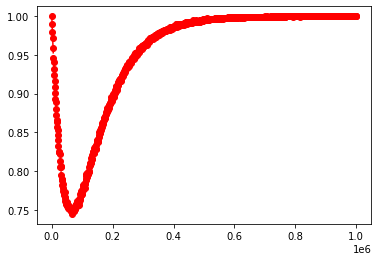

In [8]:
plt.plot(delay,b,'ro--')
plt.show()

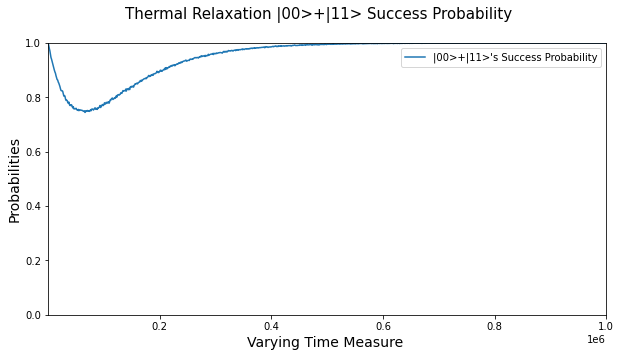

<Figure size 576x360 with 0 Axes>

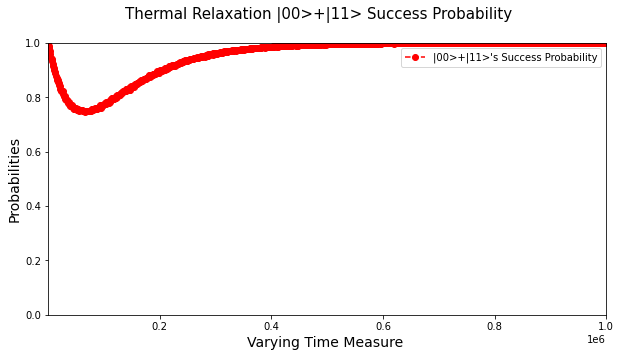

<Figure size 576x360 with 0 Axes>

In [9]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |00>+|11> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,b,label = "|00>+|11>'s Success Probability")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |00>+|11> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,b,'ro--',label = "|00>+|11>'s Success Probability")
ax.legend()

In [27]:
listofSuccess2=[]
for z in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": True, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    listofSuccess2.append(success)


In [28]:
from statistics import mean
a= listofSuccess2
print(*map(mean, zip(*a)))

0.94375 0.9372 0.9256000000000001 0.90835 0.90885 0.89645 0.886 0.87515 0.86825 0.8608 0.84605 0.8403499999999999 0.8297 0.8202499999999999 0.81085 0.7999 0.7942 0.78425 0.7746500000000001 0.76885 0.7635500000000001 0.74825 0.748 0.74095 0.72255 0.71665 0.7086 0.7078 0.69565 0.69575 0.68925 0.6777 0.6759000000000001 0.6627500000000001 0.65535 0.65145 0.64495 0.6377 0.6243 0.62005 0.6122 0.60975 0.59505 0.5964499999999999 0.5896 0.58505 0.57495 0.5719 0.56265 0.5591 0.5486500000000001 0.5394 0.54515 0.533 0.53305 0.52635 0.5147 0.51345 0.5033 0.504 0.4886 0.49215 0.49015 0.48025 0.4741 0.4681 0.46895 0.4612 0.459 0.44685 0.4473 0.4388 0.44295 0.4314 0.43074999999999997 0.4231 0.42469999999999997 0.41775 0.414 0.4053 0.40595 0.40245000000000003 0.39285000000000003 0.38815 0.38875 0.3812 0.3799 0.36985 0.3729 0.361 0.3573 0.35135 0.35955 0.3509 0.34405 0.3413 0.33735 0.3343 0.3257 0.3271 0.32655 0.321 0.32195 0.3096 0.30555 0.30045 0.30035 0.29975 0.29764999999999997 0.2982 0.2898 0.28105

In [29]:
# 20 Times Average 
b2=[0.94375,0.9372,0.9256000000000001,0.90835,0.90885,0.89645,0.886,0.87515,0.86825,0.8608,0.84605,0.8403499999999999,0.8297,0.8202499999999999,0.81085,0.7999,0.7942,0.78425,0.7746500000000001,0.76885,0.7635500000000001,0.74825,0.748,0.74095,0.72255,0.71665,0.7086,0.7078,0.69565,0.69575,0.68925,0.6777,0.6759000000000001,0.6627500000000001,0.65535,0.65145,0.64495,0.6377,0.6243,0.62005,0.6122,0.60975,0.59505,0.5964499999999999,0.5896,0.58505,0.57495,0.5719,0.56265,0.5591,0.5486500000000001,0.5394,0.54515,0.533,0.53305,0.52635,0.5147,0.51345,0.5033,0.504,0.4886,0.49215,0.49015,0.48025,0.4741,0.4681,0.46895,0.4612,0.459,0.44685,0.4473,0.4388,0.44295,0.4314,0.43074999999999997,0.4231,0.42469999999999997,0.41775,0.414,0.4053,0.40595,0.40245000000000003,0.39285000000000003,0.38815,0.38875,0.3812,0.3799,0.36985,0.3729,0.361,0.3573,0.35135,0.35955,0.3509,0.34405,0.3413,0.33735,0.3343,0.3257,0.3271,0.32655,0.321,0.32195,0.3096,0.30555,0.30045,0.30035,0.29975,0.29764999999999997,0.2982,0.2898,0.28105,0.28265,0.279,0.2796,0.27785,0.2701,0.2682,0.26405,0.26825,0.25485,0.2581,0.25355,0.25415,0.24605,0.24365,0.23855,0.24695,0.2348,0.2341,0.2403,0.2311,0.23245,0.22315,0.2251,0.2179,0.2186,0.2188,0.21365,0.2145,0.2091,0.20875,0.20285,0.20155,0.20405,0.19955,0.19285,0.2014,0.19735,0.19285,0.18605,0.18485000000000001,0.18165,0.1855,0.18325,0.17945,0.176,0.1777,0.17355,0.1749,0.1733,0.173,0.1651,0.165,0.1623,0.16335,0.1583,0.1532,0.15495,0.15395,0.15739999999999998,0.1539,0.14615,0.14905,0.14475,0.14835,0.148,0.146,0.13845,0.1382,0.1359,0.13215,0.1318,0.1346,0.13335,0.13345,0.1271,0.1256,0.1235,0.1208,0.1231,0.12335,0.124,0.1206,0.12085,0.12235,0.11185,0.11745,0.1197,0.11525,0.1108,0.10435,0.1106,0.10645,0.1053,0.1047,0.10255,0.1064,0.1009,0.1016,0.1001,0.0975,0.1,0.0969,0.0962,0.0945,0.09485,0.09635,0.0895,0.0893,0.09065,0.08765,0.08410000000000001,0.08805,0.08525,0.08645,0.0856,0.0832,0.082,0.08335,0.07615,0.07675,0.0822,0.0766,0.07894999999999999,0.0774,0.0764,0.07665,0.0735,0.072,0.07265,0.07065,0.07075000000000001,0.0704,0.06999999999999999,0.06945,0.07065,0.0667,0.0669,0.06505,0.06435,0.064,0.0644,0.0657,0.06335,0.06215,0.058499999999999996,0.0599,0.06085,0.057999999999999996,0.0564,0.055600000000000004,0.0587,0.0552,0.05865,0.05425,0.05505,0.053,0.0567,0.0519,0.052199999999999996,0.0525,0.05075,0.05075,0.05235,0.05105,0.0493,0.0489,0.045,0.047850000000000004,0.0486,0.04815,0.0472,0.04395,0.0424,0.04375,0.04215,0.0442,0.04375,0.04245,0.0437,0.0425,0.0408,0.039,0.03915,0.0415,0.038900000000000004,0.03885,0.03805,0.03825,0.0359,0.03605,0.0362,0.03665,0.0382,0.03635,0.03645,0.03495,0.03425,0.0343,0.03405,0.03385,0.0343,0.03325,0.0333,0.03215,0.03085,0.0298,0.03165,0.0305,0.03165,0.0287,0.029400000000000003,0.02755,0.03055,0.0285,0.0299,0.02885,0.0273,0.0262,0.0277,0.0275,0.02505,0.02645,0.02595,0.02705,0.0253,0.0273,0.02685,0.02605,0.02625,0.02265,0.022449999999999998,0.02335,0.0229,0.0259,0.0238,0.0218,0.023200000000000002,0.0219,0.02195,0.02315,0.021,0.0218,0.02015,0.02125,0.01875,0.0175,0.0197,0.019200000000000002,0.02095,0.01845,0.0182,0.019,0.01965,0.01775,0.01915,0.01865,0.01745,0.0181,0.0164,0.0169,0.018,0.0166,0.01665,0.017,0.0175,0.01795,0.01545,0.01675,0.0159,0.0158,0.01405,0.0147,0.014,0.01255,0.016,0.01475,0.01545,0.0151,0.0152,0.0135,0.01625,0.0132,0.0135,0.01375,0.0149,0.01295,0.01365,0.0141,0.012199999999999999,0.01355,0.0122,0.01365,0.0138,0.01345,0.01205,0.01165,0.01315,0.01175,0.01255,0.0122,0.0116,0.01135,0.0124,0.01095,0.01075,0.01075,0.00985,0.0111,0.00965,0.0103,0.0094,0.00905,0.0107,0.0108,0.009899999999999999,0.00925,0.0101,0.0085,0.00845,0.00925,0.0085,0.00945,0.0093,0.00985,0.00845,0.0089,0.009300000000000001,0.0076,0.0079,0.009,0.00865,0.0084,0.00785,0.00795,0.00845,0.0084,0.0084,0.0076,0.0077,0.008749999999999999,0.00655,0.0079,0.0067,0.00745,0.0066,0.00685,0.0075,0.0073999999999999995,0.00735,0.0070999999999999995,0.006500000000000001,0.0074,0.0073,0.00635,0.0063,0.0068,0.0064,0.0064,0.0059,0.00555,0.00575,0.0054,0.0052,0.005,0.0064,0.0056,0.00555,0.0063,0.0051,0.00565,0.0049,0.00485,0.0049,0.00525,0.0052,0.00525,0.00515,0.0053,0.00525,0.00485,0.0046500000000000005,0.00415,0.00375,0.0041,0.0045000000000000005,0.0047,0.0048000000000000004,0.0042,0.0046,0.0045,0.0043,0.00365,0.00415,0.0048000000000000004,0.0037,0.0042,0.00455,0.0038,0.0041,0.00385,0.004,0.0041,0.0038,0.004,0.0033,0.0036,0.004,0.004,0.0034000000000000002,0.00445,0.00355,0.00345,0.003,0.00425,0.00365,0.0037,0.0033,0.00365,0.0039000000000000003,0.0032500000000000003,0.004,0.00395,0.0027,0.00295,0.0034000000000000002,0.00305,0.00295,0.0025,0.00305,0.00295,0.0029000000000000002,0.0022,0.00285,0.0027,0.0023,0.00265,0.00205,0.00235,0.0027,0.0017000000000000001,0.00255,0.00255,0.00285,0.00215,0.0022,0.0028,0.0019,0.00215,0.0021,0.0029000000000000002,0.00285,0.0019,0.0022,0.0019500000000000001,0.00245,0.00115,0.0022,0.00205,0.0019,0.0019500000000000001,0.00235,0.0029000000000000002,0.00255,0.0016,0.00205,0.00165,0.00265,0.0026,0.0018,0.0019500000000000001,0.0019,0.00175,0.00175,0.00155,0.00185,0.00155,0.0014,0.0014,0.0018,0.0022,0.00165,0.0018,0.00135,0.00155,0.00125,0.0014500000000000001,0.0018,0.0018,0.0013,0.0015,0.00165,0.0013,0.0016,0.00175,0.00155,0.00115,0.00155,0.00165,0.0014500000000000001,0.0014500000000000001,0.00165,0.0008500000000000001,0.0017000000000000001,0.00125,0.0016,0.00115,0.00135,0.0013,0.0013,0.00135,0.001,0.0012000000000000001,0.00115,0.0015,0.0012000000000000001,0.0011,0.0012000000000000001,0.0013,0.00105,0.0013,0.00075,0.001,0.001,0.0014,0.00095,0.00125,0.0009,0.00105,0.0009,0.00115,0.0013,0.0008,0.00075,0.00115,0.00095,0.0009,0.0006000000000000001,0.00095,0.00115,0.00095,0.0008500000000000001,0.00065,0.00105,0.0008,0.00065,0.00075,0.00115,0.0012000000000000001,0.0009,0.00045,0.0011,0.0005,0.00105,0.0008500000000000001,0.0006000000000000001,0.00045,0.00055,0.00075,0.0006000000000000001,0.00055,0.0009,0.0006000000000000001,0.00055,0.00065,0.00035,0.0006000000000000001,0.00065,0.0007,0.0006000000000000001,0.00055,0.0008,0.00055,0.00065,0.00055,0.0008,0.00045,0.00025,0.00075,0.0006000000000000001,0.0005,0.00045,0.0005,0.0005,0.00030000000000000003,0.00045,0.00065,0.00045,0.00065,0.00055,0.0006000000000000001,0.0005,0.00065,0.00055,0.00030000000000000003,0.0005,0.0002,0.00035,0.00045,0.0004,0.00025,0.0006000000000000001,0.00035,0.0002,0.00055,0.0005,0.00035,0.0004,0.00035,0.00035,0.00045,0.00030000000000000003,0.0002,0.0005,0.0005,0.00035,0.00030000000000000003,0.00045,0.00075,0.0001,0.0006000000000000001,0.0005,0.0004,0.00035,0.00035,0.00035,0.0005,0.00030000000000000003,0.0001,0.00045,0.0002,0.00055,0.00045,0.00025,0.00030000000000000003,0.00035,0.00030000000000000003,0.00025,0.00035,0.0005,5e-05,0.00035,0.00035,0.0002,0.0002,0.00030000000000000003,0.00035,0.00025,0.00025,0.0004,0.0006000000000000001,0.00035,0.00035,0.00035,0.00035,0.00025,0.0004,0.0002,0.00015000000000000001,0.0001,0.00015000000000000001,0.00035,0.00035,0.00025,0.0001,0.00030000000000000003,0.00030000000000000003,0.00015000000000000001,0.0002,0.0001,0.00035,0.0002,5e-05,0.00015000000000000001,0.00030000000000000003,0.00025,0.00030000000000000003,0.00015000000000000001,5e-05,0.0001,0.00030000000000000003,0.0002,5e-05,0.00030000000000000003,0.0001,0.00030000000000000003,0.00015000000000000001,0.00015000000000000001,0.00030000000000000003,0.0001,0.00025,5e-05,5e-05,5e-05,5e-05,0.0001,0.00015000000000000001,0.00015000000000000001,0.0002,0.00015000000000000001,5e-05,0.0001,0.0,0.0002,0.0,0.00015000000000000001,0.00025,0.0001,0.0001,0.00025,0.0002,0.0001,0.00015000000000000001,0.0,0.0002,0.00015000000000000001,0.0001,0.00025,0.0001,0.0001,0.00015000000000000001,0.0001,0.0001,0.0001,0.0001,0.00015000000000000001,0.0001,0.00015000000000000001,0.00015000000000000001,0.00015000000000000001,0.00015000000000000001,0.0,0.00015000000000000001,0.0001,0.00015000000000000001,5e-05,0.0001,0.0002,5e-05,5e-05,0.00025,5e-05,5e-05,5e-05,0.0002,0.0001,0.0001,5e-05,0.0001,0.0,0.0,0.00025,0.0001,0.00015000000000000001,5e-05,5e-05,5e-05,0.0001,0.00015000000000000001,5e-05,0.0,5e-05,0.00015000000000000001,5e-05,0.0,5e-05,0.00015000000000000001,5e-05,0.00015000000000000001,0.00015000000000000001,5e-05,5e-05,5e-05,5e-05,5e-05,0.0,0.00015000000000000001,0.0,0.00015000000000000001,5e-05,0.00015000000000000001,0.0001,0.0001,0.0,0.00015000000000000001,0.0,0.0,0.0,5e-05,5e-05,0.0001,5e-05,5e-05,0.0001,0.0,0.0001,5e-05,0.0,5e-05,0.0001,5e-05,0.0001,5e-05,5e-05,5e-05,5e-05,0.0,5e-05,0.0,0.0001,0.0,0.0001,0.0001,5e-05,0.0,0.0,5e-05,0.0001,5e-05,0.0,5e-05,0.0,0.0,5e-05,0.0002,0.0,0.00015000000000000001,0.0,0.00015000000000000001,0.0,5e-05,0.0,0.00015000000000000001,0.0001,0.0,5e-05,0.0,5e-05,0.0,0.0,0.0,0.0,5e-05,5e-05,0.0,5e-05,0.0,0.00015000000000000001,0.0,0.0,5e-05,0.0,0.0,0.00015000000000000001,5e-05,0.0,0.0,0.0,5e-05,5e-05,0.0,5e-05,5e-05,5e-05,0.0,5e-05,0.0001,0.0,5e-05,5e-05,5e-05,5e-05,0.0001,0.0,5e-05,0.0,5e-05,5e-05,0.0,0.0,0.0001,5e-05,5e-05,5e-05,0.0001,0.0,0.0,0.0,0.0,0.0001]

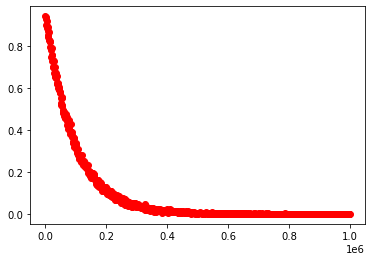

In [30]:
plt.plot(delay,success,'ro--')
plt.show()


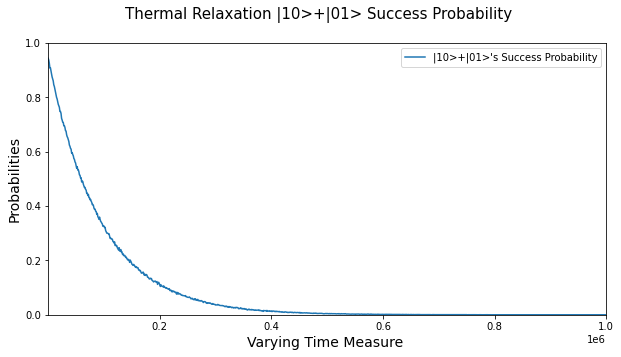

<Figure size 576x360 with 0 Axes>

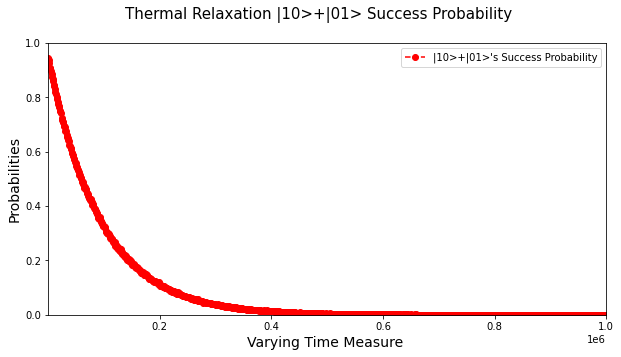

<Figure size 576x360 with 0 Axes>

In [31]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |10>+|01> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,b2,label = "|10>+|01>'s Success Probability")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |10>+|01> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,b2,'ro--',label = "|10>+|01>'s Success Probability")
ax.legend()


# Delay and Measure

In [6]:
import matplotlib.pyplot as plt

listofSuccess_DandM=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '1'
    apply_error = {"delay":True, "measure": True, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess_DandM.append(success)
    

In [10]:
from statistics import mean
a= listofSuccess_DandM
print(*map(mean, zip(*a)))

1.0 0.98935 0.9802 0.9672499999999999 0.9596 0.9529 0.94065 0.9361 0.9254 0.9176000000000001 0.9113 0.8976500000000001 0.89165 0.88915 0.87995 0.87845 0.8688 0.8634499999999999 0.85385 0.85075 0.8402499999999999 0.8371999999999999 0.8323999999999999 0.826 0.82275 0.8188 0.81835 0.8112 0.80785 0.8045 0.7966000000000001 0.7976 0.79555 0.78745 0.7866000000000001 0.7849 0.7848 0.7733 0.7748 0.7752 0.7734 0.76935 0.7693 0.7684 0.76745 0.7653 0.75515 0.7622 0.7548 0.7577 0.7611 0.75725 0.75225 0.7553 0.7544 0.75105 0.7555000000000001 0.7495 0.74715 0.7502 0.75045 0.75245 0.75065 0.7516 0.74885 0.75 0.7554 0.75625 0.75255 0.75385 0.7487 0.7535000000000001 0.75205 0.7502 0.7521 0.7529 0.7565500000000001 0.75405 0.75815 0.75475 0.7536 0.7578 0.7576 0.7612 0.75995 0.75835 0.75765 0.7579 0.7645 0.76625 0.76565 0.7627 0.76675 0.77385 0.77385 0.7675000000000001 0.7676000000000001 0.7779 0.7718 0.7725 0.77685 0.7755500000000001 0.7795500000000001 0.78 0.78345 0.78525 0.783 0.77945 0.7789 0.784600000

In [11]:
c= [1.0,0.98935,0.9802,0.9672499999999999,0.9596,0.9529,0.94065,0.9361,0.9254,0.9176000000000001,0.9113,0.8976500000000001,0.89165,0.88915,0.87995,0.87845,0.8688,0.8634499999999999,0.85385,0.85075,0.8402499999999999,0.8371999999999999,0.8323999999999999,0.826,0.82275,0.8188,0.81835,0.8112,0.80785,0.8045,0.7966000000000001,0.7976,0.79555,0.78745,0.7866000000000001,0.7849,0.7848,0.7733,0.7748,0.7752,0.7734,0.76935,0.7693,0.7684,0.76745,0.7653,0.75515,0.7622,0.7548,0.7577,0.7611,0.75725,0.75225,0.7553,0.7544,0.75105,0.7555000000000001,0.7495,0.74715,0.7502,0.75045,0.75245,0.75065,0.7516,0.74885,0.75,0.7554,0.75625,0.75255,0.75385,0.7487,0.7535000000000001,0.75205,0.7502,0.7521,0.7529,0.7565500000000001,0.75405,0.75815,0.75475,0.7536,0.7578,0.7576,0.7612,0.75995,0.75835,0.75765,0.7579,0.7645,0.76625,0.76565,0.7627,0.76675,0.77385,0.77385,0.7675000000000001,0.7676000000000001,0.7779,0.7718,0.7725,0.77685,0.7755500000000001,0.7795500000000001,0.78,0.78345,0.78525,0.783,0.77945,0.7789,0.7846000000000001,0.7807000000000001,0.7886500000000001,0.7887500000000001,0.79035,0.7957500000000001,0.79415,0.80005,0.79835,0.8014,0.80125,0.8047,0.7984,0.80405,0.8038,0.8053,0.80515,0.8089500000000001,0.8086,0.80905,0.81445,0.8082,0.81275,0.82025,0.8185,0.8177,0.8199,0.8233,0.81765,0.8264,0.8202499999999999,0.821,0.83715,0.82555,0.82955,0.82745,0.83485,0.8373499999999999,0.8335,0.84215,0.83675,0.84085,0.83875,0.84115,0.8432499999999999,0.8389,0.8452999999999999,0.8462,0.84865,0.8492999999999999,0.8512,0.84925,0.8516,0.8566,0.8543499999999999,0.8537,0.85415,0.8593,0.86095,0.8606,0.86655,0.862,0.86265,0.8694999999999999,0.8654499999999999,0.87015,0.86675,0.87335,0.8734,0.87045,0.8737,0.8744,0.8785000000000001,0.8742,0.87675,0.87855,0.88295,0.8842,0.88405,0.8828,0.8838,0.88805,0.8879,0.8878,0.8894,0.8946500000000001,0.889,0.8906000000000001,0.8912,0.89525,0.8915500000000001,0.8976500000000001,0.8986500000000001,0.8938,0.8972,0.8985000000000001,0.8999,0.9016500000000001,0.9028,0.9033,0.90605,0.90785,0.9052,0.9064,0.90435,0.90705,0.9102,0.908,0.91045,0.9139,0.9159,0.9143,0.9131,0.9135,0.9136000000000001,0.9175,0.91795,0.9165500000000001,0.9193,0.9202,0.9184,0.9238000000000001,0.9203,0.92235,0.92555,0.9244,0.9262,0.92655,0.92635,0.9257500000000001,0.93215,0.9268000000000001,0.92835,0.92895,0.9326,0.9294,0.93435,0.933,0.93385,0.93685,0.9345,0.9369,0.9361,0.93345,0.9390499999999999,0.94245,0.9378,0.94065,0.9367,0.94075,0.9417,0.9414,0.94405,0.94365,0.94495,0.9447,0.94505,0.9463999999999999,0.9451999999999999,0.94795,0.94575,0.9465,0.9495,0.9479,0.947,0.95185,0.94945,0.9494499999999999,0.9504499999999999,0.9521999999999999,0.953,0.953,0.9541999999999999,0.95065,0.95595,0.9551,0.9542499999999999,0.9552499999999999,0.95705,0.9579,0.95795,0.9577,0.9581,0.9566,0.9566,0.9579,0.9607,0.962,0.9614499999999999,0.9611999999999999,0.96355,0.96295,0.9626,0.96165,0.9611,0.962,0.96095,0.9633499999999999,0.96205,0.9659,0.96315,0.9651,0.96605,0.9664499999999999,0.96485,0.9651,0.9672499999999999,0.96685,0.96905,0.9682999999999999,0.9672,0.96695,0.96815,0.9663999999999999,0.9689,0.971,0.9682999999999999,0.97005,0.97015,0.9708,0.9714499999999999,0.9726,0.972,0.971,0.9743999999999999,0.9735,0.97065,0.97265,0.97325,0.97295,0.9726,0.9732999999999999,0.9762,0.975,0.97495,0.9753999999999999,0.9743999999999999,0.9767,0.9772,0.97795,0.9746,0.9783,0.9756,0.9793499999999999,0.9783999999999999,0.9768,0.9787,0.97995,0.9794499999999999,0.9783499999999999,0.9807,0.97965,0.97825,0.9802,0.982,0.9784999999999999,0.97925,0.9817,0.98065,0.9819,0.98105,0.9807,0.9812,0.98215,0.9818,0.9843,0.9827,0.98055,0.98055,0.98325,0.98335,0.98325,0.9836,0.9819,0.98495,0.9831,0.98225,0.98435,0.9843,0.98535,0.9853999999999999,0.98365,0.9852,0.9852,0.9841,0.98685,0.98695,0.9847,0.9848,0.9864999999999999,0.9873999999999999,0.98775,0.9872,0.9858,0.9867,0.9868,0.9873999999999999,0.9866,0.9882,0.9877,0.98705,0.98755,0.98765,0.9881,0.98755,0.9873,0.98675,0.9882,0.9894,0.9877,0.9896,0.9894499999999999,0.9884499999999999,0.9887,0.9886,0.98875,0.9893,0.9896,0.99125,0.9898,0.9904499999999999,0.9901,0.99175,0.98985,0.9913,0.9895,0.99095,0.992,0.9914,0.99155,0.991,0.9902,0.9898,0.991,0.99125,0.9915,0.9909,0.99135,0.99235,0.9919,0.99175,0.9924,0.9917,0.992,0.9912,0.9918,0.991,0.99185,0.9924999999999999,0.9924,0.99195,0.99305,0.9935,0.99355,0.9938,0.99365,0.99385,0.9923,0.9939,0.99315,0.9934499999999999,0.99355,0.99405,0.9931,0.99425,0.99395,0.99365,0.9943,0.99305,0.99355,0.99425,0.99325,0.9947,0.9948,0.99495,0.99395,0.99475,0.995,0.9943,0.99525,0.99455,0.9944999999999999,0.99385,0.99475,0.99425,0.9956,0.99585,0.99505,0.9937,0.9951,0.9952,0.9956,0.99455,0.99495,0.9963,0.99555,0.9949,0.996,0.99545,0.99615,0.9962,0.9958,0.996,0.9957,0.99575,0.99555,0.9967,0.9966,0.996,0.9962,0.99645,0.99615,0.9959,0.99595,0.9963,0.9961,0.99645,0.9962,0.9966,0.9979,0.99655,0.9964,0.9963,0.99705,0.9961,0.9975,0.9961,0.99645,0.99705,0.9972,0.9968,0.99655,0.9973,0.99705,0.99705,0.9968,0.99655,0.99785,0.99725,0.9976,0.9967,0.99715,0.99705,0.99725,0.99695,0.9973,0.997,0.9974,0.99755,0.99705,0.99685,0.99795,0.99765,0.99715,0.99725,0.9978,0.9977,0.9976,0.9976,0.9981,0.99825,0.9976,0.99745,0.9984999999999999,0.99805,0.9983,0.99785,0.99785,0.99805,0.99855,0.99805,0.9984,0.9982,0.9982,0.99805,0.9975,0.99805,0.998,0.99815,0.9986,0.99845,0.9986,0.99835,0.9986,0.99815,0.9976,0.9978,0.99845,0.99865,0.9984999999999999,0.9981,0.999,0.9989,0.9984999999999999,0.99865,0.9982,0.9984,0.9986,0.99845,0.9984,0.9986,0.99805,0.99845,0.99885,0.9984999999999999,0.9991,0.999,0.99895,0.99845,0.9987,0.99855,0.99855,0.99835,0.99875,0.9991,0.9989,0.99935,0.99885,0.99895,0.99895,0.9988,0.9984999999999999,0.9987,0.999,0.9989,0.9992,0.99875,0.9989,0.9992,0.99895,0.99895,0.99925,0.999,0.9989,0.9991,0.9989,0.99875,0.9992,0.9989,0.99935,0.9989,0.9991,0.9992,0.99905,0.9989,0.99935,0.9996,0.99915,0.99925,0.999,0.9989,0.99945,0.99925,0.99965,0.999,0.9989,0.9989,0.99915,0.99905,0.99945,0.99935,0.9993,0.9992,0.9989,0.99935,0.9993,0.99895,0.9992,0.9994,0.99965,0.99915,0.99885,0.9993,0.99925,0.99925,0.9994,0.99915,0.99945,0.9991,0.99935,0.99935,0.99965,0.99915,0.99935,0.99965,0.99935,0.99955,0.99935,0.9995,0.99955,0.99955,0.99965,0.99955,0.99945,0.99955,0.9996,0.99955,0.9995,0.9994,0.99935,0.99975,0.99935,0.99955,0.9994,0.99975,0.99945,0.9994,0.9995,0.99955,0.9995,0.9995,0.9995,0.99945,0.99925,0.99975,0.9998,0.9995,0.9996,0.99985,0.9995,0.99955,0.99965,0.9995,0.9994,0.9995,0.9997,0.99915,0.99965,0.9997,0.9998,0.99975,0.99965,0.99925,0.99955,0.99975,0.99985,0.9997,0.99965,0.99985,0.99975,0.9993,0.99995,0.9998,0.99975,0.9997,0.99965,0.99965,0.99965,0.9996,0.9998,0.9997,0.9999,0.99945,0.99985,0.99985,0.9998,0.9998,0.99975,0.9997,0.9998,0.9999,0.9998,0.9999,0.9998,0.99975,0.99985,0.9999,0.9998,0.99975,0.99975,0.9999,0.99975,0.9998,0.9998,0.9998,0.99985,0.99975,0.9997,0.99985,0.9998,0.9996,0.9999,0.9997,0.99985,0.9998,0.99965,0.9998,0.9997,0.9996,0.9997,0.9998,0.99985,0.99985,0.99985,0.9998,0.9999,0.99985,0.9998,0.9998,0.99975,0.99975,0.9998,0.99995,0.99985,0.99975,0.9999,0.99965,0.99995,0.9998,0.99995,0.99985,0.99995,0.99985,0.9999,0.99985,0.99995,0.99995,0.99995,0.99975,0.9997,0.9999,1.0,0.9997,0.99985,0.99995,0.9999,0.99985,0.99985,0.99985,0.99995,0.99995,0.99975,0.99985,0.99985,0.99985,0.9998,1.0,0.99995,0.9999,0.99985,0.99985,0.99985,0.9998,0.99985,0.99995,0.99985,0.99975,0.9999,0.99995,0.99995,0.9999,0.99995,0.9999,0.9999,1.0,0.99995,0.9999,0.99995,0.9999,1.0,1.0,0.99995,0.9999,0.99995,0.99975,1.0,0.9999,0.99985,0.9999,0.99995,0.9998,1.0,1.0,0.99985,1.0,0.9999,0.99995,0.9999,0.99995,0.9999,0.99995,0.99995,0.99995,0.9998,0.99995,1.0,0.9999,0.99985,1.0,0.99995,0.9999,0.9999,0.99995,0.9999,0.99995,0.99995,0.99995,0.9999,0.99995,0.99995,0.99995,0.9999,0.99995,0.99995,0.99995,0.9999,1.0,1.0,0.9999,1.0,0.9999,0.9999,1.0,0.99995,0.99995,1.0,0.9998,0.99995,1.0,1.0,0.99995,0.99995,0.99995,0.99995,0.99995,0.99995,0.99995,1.0,1.0,1.0,1.0,1.0,1.0,0.9999,1.0,0.99995,1.0,0.99995,0.99995,0.99995,1.0,0.9999,0.9999,1.0,0.99995,0.9999,1.0,0.99985,1.0,0.99995,0.99995,1.0,1.0,1.0,0.99995,0.99995,1.0,0.99995,0.99995,0.99995,0.99995,1.0,1.0,1.0,0.9999,1.0,1.0,0.99995,0.99995,0.99995,1.0,1.0,0.99995,0.9999,0.9999,1.0,1.0,1.0,0.99995,0.99995,1.0,1.0,1.0,1.0,1.0,0.9999,1.0,0.9999,1.0,1.0,1.0,1.0]

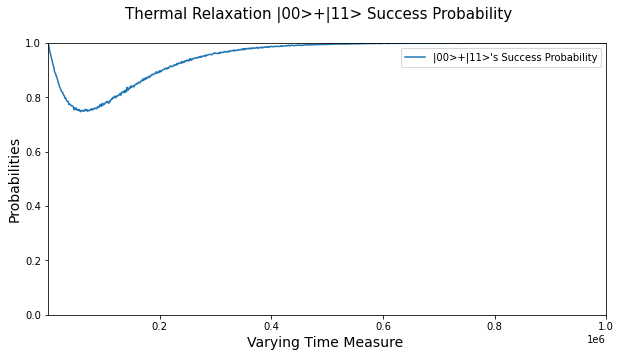

<Figure size 576x360 with 0 Axes>

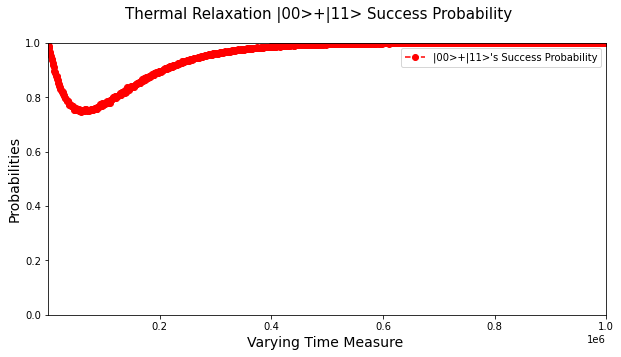

<Figure size 576x360 with 0 Axes>

In [14]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |00>+|11> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,c,label = "|00>+|11>'s Success Probability")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |00>+|11> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,c,'ro--',label = "|00>+|11>'s Success Probability")
ax.legend()

In [15]:
import matplotlib.pyplot as plt

listofSuccess_DandM2=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": True, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess_DandM2.append(success)
    

In [16]:
from statistics import mean
a= listofSuccess_DandM2
print(*map(mean, zip(*a)))

0.9447 0.93415 0.9226000000000001 0.91415 0.9049 0.8966000000000001 0.88615 0.8768 0.86265 0.8594499999999999 0.84825 0.8387 0.8295 0.8201499999999999 0.8146 0.802 0.79195 0.7853 0.77775 0.76975 0.7589 0.7494 0.7413 0.74505 0.7262 0.7199 0.71985 0.70575 0.7019 0.695 0.6871 0.67405 0.67095 0.6646000000000001 0.6598 0.6478 0.6444 0.6333 0.63085 0.62675 0.61415 0.60275 0.6 0.58905 0.5839 0.5871 0.58195 0.57325 0.5640499999999999 0.5605 0.55635 0.546 0.53905 0.5398000000000001 0.5272 0.524 0.51515 0.51145 0.5073 0.50395 0.49470000000000003 0.49295 0.4834 0.48205 0.4755 0.47495 0.46225 0.4625 0.4529 0.4508 0.4434 0.4393 0.44385 0.4291 0.42715 0.4235 0.417 0.41165 0.4097 0.40475 0.4027 0.39465 0.38855 0.3926 0.38095 0.38525 0.3745 0.37115 0.36685 0.36605 0.35609999999999997 0.3552 0.3559 0.34565 0.33845000000000003 0.3404 0.34199999999999997 0.3294 0.33085000000000003 0.32075 0.3255 0.31905 0.31305 0.3154 0.30855 0.3052 0.3023 0.2996 0.29565 0.30025 0.2942 0.2899 0.28415 0.2812 0.2781 0.2741

In [17]:
c2=[0.9447,0.93415,0.9226000000000001,0.91415,0.9049,0.8966000000000001,0.88615,0.8768,0.86265,0.8594499999999999,0.84825,0.8387,0.8295,0.8201499999999999,0.8146,0.802,0.79195,0.7853,0.77775,0.76975,0.7589,0.7494,0.7413,0.74505,0.7262,0.7199,0.71985,0.70575,0.7019,0.695,0.6871,0.67405,0.67095,0.6646000000000001,0.6598,0.6478,0.6444,0.6333,0.63085,0.62675,0.61415,0.60275,0.6,0.58905,0.5839,0.5871,0.58195,0.57325,0.5640499999999999,0.5605,0.55635,0.546,0.53905,0.5398000000000001,0.5272,0.524,0.51515,0.51145,0.5073,0.50395,0.49470000000000003,0.49295,0.4834,0.48205,0.4755,0.47495,0.46225,0.4625,0.4529,0.4508,0.4434,0.4393,0.44385,0.4291,0.42715,0.4235,0.417,0.41165,0.4097,0.40475,0.4027,0.39465,0.38855,0.3926,0.38095,0.38525,0.3745,0.37115,0.36685,0.36605,0.35609999999999997,0.3552,0.3559,0.34565,0.33845000000000003,0.3404,0.34199999999999997,0.3294,0.33085000000000003,0.32075,0.3255,0.31905,0.31305,0.3154,0.30855,0.3052,0.3023,0.2996,0.29565,0.30025,0.2942,0.2899,0.28415,0.2812,0.2781,0.2741,0.2685,0.26855,0.2654,0.26165,0.2586,0.25805,0.2538,0.2504,0.25435,0.24195,0.24625,0.2402,0.24095,0.2361,0.23495,0.22885,0.2263,0.2262,0.22485,0.227,0.2243,0.21825,0.21595,0.20895,0.2051,0.21395,0.2052,0.20485,0.20305,0.20005,0.1985,0.19855,0.191,0.19185,0.19055,0.1845,0.1814,0.18195,0.17830000000000001,0.1792,0.1719,0.1732,0.1756,0.17345,0.1723,0.1699,0.1677,0.16620000000000001,0.1622,0.1619,0.15535,0.16035,0.15595,0.15295,0.15575,0.1529,0.152,0.14865,0.14855,0.14995,0.14475,0.1391,0.13935,0.1372,0.1387,0.1332,0.1386,0.1336,0.1306,0.13395,0.1281,0.1255,0.12825,0.12135,0.12325,0.1201,0.12485,0.11895,0.12105,0.11995,0.1142,0.1201,0.11235,0.11005000000000001,0.11345,0.10745,0.1074,0.10885,0.10685,0.1047,0.1058,0.1009,0.1027,0.10365,0.0973,0.09815,0.0926,0.09775,0.0913,0.0934,0.0937,0.0916,0.09135,0.0877,0.0869,0.0886,0.0848,0.0866,0.08499999999999999,0.08360000000000001,0.08715,0.0833,0.08315,0.0802,0.0819,0.0786,0.07925,0.07894999999999999,0.08085,0.07635,0.07575,0.07515,0.07695,0.07375,0.07375,0.07225,0.06915,0.068,0.0669,0.06845,0.07065,0.0663,0.0662,0.06615,0.0657,0.0664,0.0618,0.06395,0.0606,0.0591,0.0579,0.0596,0.0606,0.05935,0.0581,0.05685,0.05635,0.05575,0.05345,0.05675,0.054,0.05595,0.0523,0.0496,0.0494,0.0521,0.0511,0.0507,0.04935,0.0502,0.05045,0.0478,0.0487,0.0459,0.047850000000000004,0.04915,0.04745,0.04745,0.04615,0.04315,0.0442,0.04375,0.0415,0.04215,0.0405,0.0422,0.04185,0.04475,0.03905,0.04325,0.0379,0.0424,0.03795,0.0401,0.0378,0.0386,0.0398,0.037,0.038,0.03495,0.0362,0.035500000000000004,0.03415,0.03785,0.03515,0.03395,0.0331,0.0317,0.0328,0.0337,0.03325,0.03245,0.02935,0.0292,0.03155,0.0276,0.0285,0.0317,0.0291,0.02735,0.02885,0.027200000000000002,0.02875,0.0294,0.0282,0.0279,0.02845,0.0266,0.0265,0.02475,0.0254,0.02645,0.0267,0.02435,0.02535,0.022949999999999998,0.02585,0.02205,0.0225,0.02305,0.02535,0.0215,0.0235,0.0229,0.0206,0.02245,0.0211,0.02115,0.0214,0.0184,0.01985,0.01965,0.0215,0.02035,0.0208,0.0201,0.0184,0.01855,0.0195,0.0194,0.0204,0.01745,0.01685,0.01615,0.0173,0.0183,0.0163,0.0176,0.0174,0.01685,0.01745,0.01785,0.0174,0.01605,0.01685,0.01645,0.017,0.0145,0.0152,0.0146,0.0163,0.015349999999999999,0.0155,0.01525,0.0134,0.01425,0.01455,0.01385,0.014,0.01185,0.0132,0.0139,0.01335,0.012799999999999999,0.0129,0.013649999999999999,0.0133,0.01145,0.01095,0.01145,0.01145,0.01175,0.012,0.0121,0.01245,0.012199999999999999,0.0101,0.01155,0.01175,0.00915,0.0105,0.0112,0.0105,0.01055,0.0104,0.01165,0.01015,0.01105,0.0097,0.0103,0.0105,0.00925,0.00975,0.0091,0.00985,0.00985,0.00995,0.00955,0.009349999999999999,0.00975,0.0078,0.00855,0.0085,0.00745,0.0081,0.00885,0.0077,0.0087,0.0082,0.0075,0.008,0.0077,0.0073,0.00735,0.00785,0.00755,0.00705,0.0071,0.00825,0.0074,0.0069,0.0074,0.0062,0.00635,0.00715,0.0071,0.0078,0.0059,0.0061,0.00705,0.00545,0.00645,0.0065,0.0062,0.00635,0.0071,0.00555,0.00535,0.0057,0.0057,0.0058,0.005,0.00635,0.00585,0.00655,0.00535,0.0051,0.00645,0.00545,0.00505,0.00555,0.00565,0.004,0.00495,0.00525,0.005,0.00485,0.00505,0.0044,0.0051,0.0044,0.0048000000000000004,0.0049,0.00415,0.0052,0.004,0.00375,0.0036,0.0047,0.0036,0.0041,0.0045000000000000005,0.00395,0.00385,0.0048000000000000004,0.0041,0.00405,0.00395,0.00305,0.004,0.0041,0.0037,0.00405,0.00405,0.00315,0.00395,0.00375,0.0032,0.00365,0.0035,0.0028,0.004,0.0032,0.004,0.00285,0.0033,0.0031,0.0032500000000000003,0.00235,0.00355,0.00345,0.003,0.0033,0.003,0.00335,0.00275,0.0036,0.003,0.0029000000000000002,0.0029000000000000002,0.00335,0.0024000000000000002,0.00305,0.00285,0.003,0.0029000000000000002,0.0022,0.00275,0.0028,0.00235,0.0022500000000000003,0.0024000000000000002,0.00245,0.0021,0.0023,0.00175,0.0025,0.003,0.0021,0.0019,0.00255,0.0022500000000000003,0.00185,0.0022500000000000003,0.00255,0.0022500000000000003,0.00205,0.002,0.0015,0.0022,0.00165,0.0019500000000000001,0.0014,0.0014500000000000001,0.0019500000000000001,0.0023,0.0015,0.0014,0.002,0.00185,0.00165,0.00135,0.0021,0.0018,0.0013,0.00175,0.00155,0.00185,0.0016,0.0018,0.0016,0.00135,0.00105,0.00135,0.0017000000000000001,0.00165,0.0017000000000000001,0.0014500000000000001,0.0021,0.0016,0.0016,0.00155,0.00125,0.00185,0.0012000000000000001,0.0015,0.00095,0.0014,0.0014,0.0018,0.0012000000000000001,0.0017000000000000001,0.0011,0.00105,0.0015,0.0012000000000000001,0.00105,0.00105,0.00115,0.001,0.0007,0.0009,0.0008500000000000001,0.00075,0.0008500000000000001,0.0013,0.0012000000000000001,0.0012000000000000001,0.0008500000000000001,0.0008500000000000001,0.00095,0.00095,0.0006000000000000001,0.0013,0.00065,0.0009,0.0012000000000000001,0.0006000000000000001,0.0014,0.00055,0.00125,0.00095,0.001,0.00105,0.00125,0.0006000000000000001,0.0011,0.00105,0.0006000000000000001,0.00075,0.0008,0.00045,0.00045,0.00055,0.0006000000000000001,0.00065,0.00095,0.00115,0.0009,0.0006000000000000001,0.00075,0.001,0.0009,0.0009,0.0006000000000000001,0.0005,0.0006000000000000001,0.0008500000000000001,0.0009,0.00075,0.0005,0.0006000000000000001,0.0008500000000000001,0.00045,0.00075,0.0005,0.0008500000000000001,0.0005,0.00055,0.00055,0.0006000000000000001,0.0007,0.0006000000000000001,0.0008,0.00055,0.0006000000000000001,0.0004,0.0005,0.00035,0.00065,0.0006000000000000001,0.00045,0.00055,0.00065,0.0002,0.00045,0.00065,0.0006000000000000001,0.00065,0.0006000000000000001,0.0005,0.00065,0.0005,0.00015000000000000001,0.00055,0.0007,0.0004,0.00030000000000000003,0.0005,0.0004,0.0004,0.00055,0.00035,0.00065,0.0006000000000000001,0.0004,0.00015000000000000001,0.00045,0.00025,0.0007,0.0004,0.00015000000000000001,0.00025,0.0004,0.00035,0.0002,0.00025,0.0002,0.00035,0.0004,0.00035,0.0004,0.0004,0.00025,0.00025,0.00045,0.00025,0.00035,0.00045,0.0005,0.00025,0.0007,0.0001,0.00015000000000000001,0.00035,0.00025,0.00035,0.00025,0.00030000000000000003,0.00035,0.00045,0.00030000000000000003,0.00045,0.00025,0.0004,0.0002,0.00030000000000000003,0.0004,0.0002,0.0001,0.0001,0.00035,0.00035,0.00025,0.00030000000000000003,0.0005,0.0002,0.00025,0.00015000000000000001,0.0002,0.0002,0.00025,0.00030000000000000003,0.00035,0.0002,0.00030000000000000003,0.00030000000000000003,0.00025,5e-05,0.00015000000000000001,0.0002,0.0001,0.00030000000000000003,0.00025,0.00030000000000000003,0.00015000000000000001,0.00015000000000000001,0.00035,0.00030000000000000003,0.00030000000000000003,0.00030000000000000003,0.00030000000000000003,5e-05,0.00030000000000000003,0.00045,5e-05,0.00015000000000000001,5e-05,0.00015000000000000001,0.00025,0.0002,0.0001,0.0001,0.0002,0.00015000000000000001,0.0001,0.00015000000000000001,0.0001,0.0001,0.0002,0.00015000000000000001,0.00015000000000000001,0.00015000000000000001,0.0,0.0002,0.00015000000000000001,0.00015000000000000001,0.00025,0.0001,0.00015000000000000001,0.0001,0.00015000000000000001,0.0001,0.0001,0.00015000000000000001,0.0002,0.0001,5e-05,0.0001,0.00015000000000000001,0.00015000000000000001,5e-05,5e-05,0.0001,0.0,0.0,5e-05,0.0002,0.0,5e-05,0.0,0.0001,0.0001,0.0001,0.00015000000000000001,5e-05,0.0001,5e-05,0.0001,0.0002,0.0001,5e-05,0.00015000000000000001,5e-05,0.0001,0.00015000000000000001,0.0001,5e-05,5e-05,0.00015000000000000001,0.0,0.0002,0.0001,5e-05,0.0,0.0001,5e-05,0.0002,0.0001,0.0001,5e-05,5e-05,5e-05,0.0001,0.0,0.0001,5e-05,5e-05,0.0,5e-05,5e-05,0.0002,5e-05,0.00015000000000000001,5e-05,0.0,5e-05,5e-05,0.0,0.0001,5e-05,0.0001,0.0,0.0,0.0001,5e-05,0.00015000000000000001,0.0,5e-05,0.0,0.0,5e-05,0.0001,0.0001,0.0001,5e-05,0.0001,5e-05,0.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,5e-05,0.0,0.0001,0.0001,5e-05,5e-05,5e-05,5e-05,0.0,0.0,0.0,5e-05,5e-05,0.00015000000000000001,0.0,5e-05,5e-05,5e-05,5e-05,0.0,5e-05,0.0,5e-05,0.0,5e-05,0.0,0.0,0.0,5e-05,0.0,5e-05,5e-05,0.0,5e-05,5e-05,5e-05,0.0,0.0,0.0,0.0,5e-05,0.0,5e-05,5e-05,0.0001,0.0,0.0001,0.0,0.0001,5e-05,0.0,5e-05,0.0,5e-05,5e-05,0.0,5e-05,5e-05,5e-05,0.0001,5e-05,5e-05,0.0,5e-05,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,5e-05]

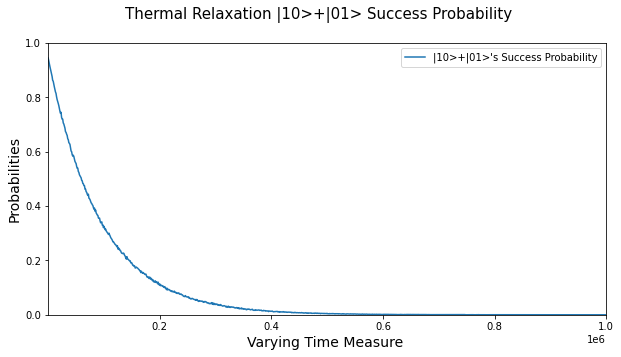

<Figure size 576x360 with 0 Axes>

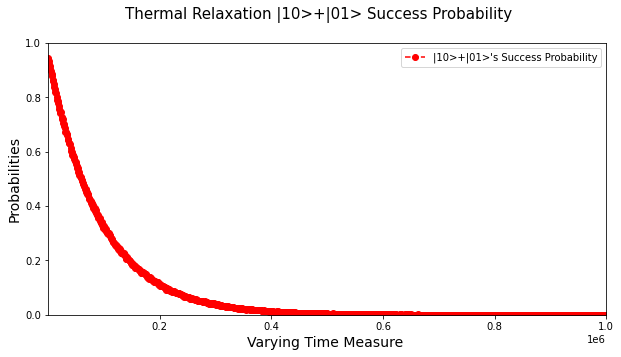

<Figure size 576x360 with 0 Axes>

In [18]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |10>+|01> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,c2,label = "|10>+|01>'s Success Probability")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |10>+|01> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,c2,'ro--',label = "|10>+|01>'s Success Probability")
ax.legend()

# Delay, Measure and Gate

In [19]:
import matplotlib.pyplot as plt

listofSuccess_DMG=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '1'
    apply_error = {"delay":True, "measure": True, "gate": True}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess_DMG.append(success)
    

In [20]:
from statistics import mean
a= listofSuccess_DMG
print(*map(mean, zip(*a)))

0.94235 0.93745 0.92415 0.91695 0.9118 0.90645 0.8991 0.8896000000000001 0.8816 0.8751 0.8697 0.8638 0.858 0.8492 0.8418 0.8382 0.8359 0.82565 0.82095 0.82025 0.81795 0.81745 0.81195 0.79815 0.7995 0.7984 0.7895000000000001 0.7889 0.7921 0.7827500000000001 0.78485 0.78145 0.7808 0.77345 0.7715500000000001 0.7751 0.7681 0.76865 0.77015 0.7627 0.76545 0.7613 0.7621 0.7615000000000001 0.75835 0.753 0.7588 0.7528 0.7523 0.7529 0.7573 0.75505 0.7487 0.75465 0.7482 0.7438 0.74545 0.7481 0.7506 0.75365 0.7454 0.75455 0.7551 0.7455 0.7494 0.7501 0.7552 0.7472 0.75045 0.757 0.75345 0.7424999999999999 0.7561 0.7517 0.7542 0.75535 0.7558 0.75735 0.7637 0.75775 0.7588 0.76415 0.759 0.76935 0.76875 0.76945 0.76465 0.76725 0.7726000000000001 0.7741 0.77245 0.7715000000000001 0.77045 0.7719 0.767 0.77345 0.7743 0.7813 0.77815 0.78305 0.7835500000000001 0.78795 0.7837000000000001 0.78515 0.788 0.7877000000000001 0.79015 0.79295 0.7971 0.7947500000000001 0.7998500000000001 0.7896500000000001 0.80080000

In [23]:
d= [0.94235,0.93745,0.92415,0.91695,0.9118,0.90645,0.8991,0.8896000000000001,0.8816,0.8751,0.8697,0.8638,0.858,0.8492,0.8418,0.8382,0.8359,0.82565,0.82095,0.82025,0.81795,0.81745,0.81195,0.79815,0.7995,0.7984,0.7895000000000001,0.7889,0.7921,0.7827500000000001,0.78485,0.78145,0.7808,0.77345,0.7715500000000001,0.7751,0.7681,0.76865,0.77015,0.7627,0.76545,0.7613,0.7621,0.7615000000000001,0.75835,0.753,0.7588,0.7528,0.7523,0.7529,0.7573,0.75505,0.7487,0.75465,0.7482,0.7438,0.74545,0.7481,0.7506,0.75365,0.7454,0.75455,0.7551,0.7455,0.7494,0.7501,0.7552,0.7472,0.75045,0.757,0.75345,0.7424999999999999,0.7561,0.7517,0.7542,0.75535,0.7558,0.75735,0.7637,0.75775,0.7588,0.76415,0.759,0.76935,0.76875,0.76945,0.76465,0.76725,0.7726000000000001,0.7741,0.77245,0.7715000000000001,0.77045,0.7719,0.767,0.77345,0.7743,0.7813,0.77815,0.78305,0.7835500000000001,0.78795,0.7837000000000001,0.78515,0.788,0.7877000000000001,0.79015,0.79295,0.7971,0.7947500000000001,0.7998500000000001,0.7896500000000001,0.8008000000000001,0.7967000000000001,0.806,0.80095,0.7999,0.8072,0.80725,0.80575,0.81005,0.8081,0.8132,0.812,0.81565,0.80875,0.81565,0.8186,0.8205,0.81985,0.8232499999999999,0.82475,0.82335,0.8232999999999999,0.82595,0.8266,0.8278,0.83155,0.835,0.8361,0.83555,0.83675,0.8386,0.83265,0.8392499999999999,0.8393499999999999,0.84775,0.84395,0.8414999999999999,0.84715,0.84775,0.8432,0.84875,0.85085,0.85565,0.85515,0.85555,0.85675,0.8572,0.86075,0.86165,0.8593999999999999,0.86265,0.8599,0.86565,0.872,0.8661,0.86465,0.8714999999999999,0.8694999999999999,0.8734,0.8673,0.8752,0.8718,0.8778,0.87525,0.8773,0.87885,0.8851,0.88495,0.87715,0.87715,0.8841,0.8875,0.8822,0.88605,0.88805,0.88965,0.8947,0.8924,0.89225,0.8892,0.8959,0.8978,0.90005,0.89925,0.90145,0.89745,0.8988,0.90215,0.9031,0.90075,0.9055500000000001,0.9072,0.9015500000000001,0.9079,0.9073,0.9077000000000001,0.90945,0.91195,0.91115,0.9118,0.91025,0.91485,0.9127000000000001,0.91635,0.9165000000000001,0.9182,0.91795,0.9159,0.91715,0.91715,0.9197000000000001,0.921,0.92135,0.9229,0.9239,0.9247000000000001,0.9266500000000001,0.9277500000000001,0.9328500000000001,0.9268500000000001,0.9289000000000001,0.9257000000000001,0.92805,0.93165,0.9297000000000001,0.933,0.9318500000000001,0.93245,0.9339500000000001,0.9322,0.9328000000000001,0.935,0.934,0.93665,0.9349000000000001,0.9385,0.9351,0.9390499999999999,0.9376,0.9416,0.9433,0.94175,0.9432499999999999,0.94455,0.94315,0.9446,0.94335,0.94655,0.94485,0.9451499999999999,0.9466,0.94555,0.9463999999999999,0.9472999999999999,0.94865,0.9499,0.94865,0.9516,0.9499,0.95195,0.9531499999999999,0.95265,0.95375,0.9513499999999999,0.9535,0.95185,0.954,0.95355,0.9556,0.95755,0.95785,0.95965,0.9562499999999999,0.95915,0.95765,0.9573499999999999,0.9582999999999999,0.9622499999999999,0.95955,0.95715,0.9621999999999999,0.9616,0.9614499999999999,0.9619,0.9642999999999999,0.9604999999999999,0.96185,0.9635,0.96315,0.964,0.96375,0.9632,0.96575,0.96555,0.9654499999999999,0.9646,0.96475,0.9684499999999999,0.96655,0.96715,0.9709,0.9684499999999999,0.96815,0.96995,0.971,0.9713999999999999,0.9692999999999999,0.971,0.9721,0.9736,0.97165,0.9717,0.9702999999999999,0.9723999999999999,0.9724999999999999,0.9703499999999999,0.9726,0.9724499999999999,0.97365,0.9761,0.9733499999999999,0.97515,0.9746,0.97495,0.9753999999999999,0.9756,0.9748,0.9763499999999999,0.9744999999999999,0.9753999999999999,0.97675,0.9777,0.97655,0.97575,0.97685,0.97705,0.9763499999999999,0.9753,0.9793499999999999,0.98025,0.97905,0.97975,0.97955,0.9786,0.9803,0.98215,0.9793499999999999,0.97925,0.97975,0.98065,0.9796,0.981,0.9822,0.98275,0.9824999999999999,0.9813,0.98185,0.98165,0.98155,0.98205,0.9851,0.98325,0.98315,0.98215,0.9843,0.9836,0.985,0.9834499999999999,0.9829,0.9842,0.9847,0.9854499999999999,0.9855,0.98435,0.9838,0.9857,0.9847,0.9861,0.98555,0.98575,0.9867,0.98515,0.98735,0.9869,0.9851,0.98665,0.98605,0.988,0.9873999999999999,0.9877,0.98755,0.9878,0.9866,0.989,0.9883,0.9884,0.9876,0.98765,0.9895,0.9882,0.9886,0.9886,0.9884999999999999,0.9886,0.9901,0.9886,0.9904499999999999,0.98935,0.9902,0.98905,0.9898,0.9894499999999999,0.98985,0.9917,0.99105,0.9895,0.99075,0.9906,0.98905,0.9909,0.9917,0.9922,0.9904,0.99125,0.99055,0.9902,0.9909,0.9929,0.99225,0.99125,0.99105,0.99185,0.99185,0.99255,0.9924499999999999,0.99225,0.9922,0.9933,0.9926,0.9936,0.99205,0.9934,0.9934,0.9933,0.9931,0.99275,0.99225,0.99405,0.99285,0.99295,0.99375,0.99285,0.9939,0.9933,0.99365,0.9939,0.99395,0.99355,0.9929,0.99385,0.9939,0.99465,0.99385,0.99525,0.99405,0.99355,0.9941,0.99385,0.9948,0.99425,0.9939,0.9947,0.995,0.99455,0.9937,0.9946,0.9943,0.9954,0.9947,0.9958,0.9963,0.995,0.99525,0.99575,0.9952,0.9955,0.99505,0.9958,0.9954,0.9968,0.99595,0.99615,0.9957,0.9953,0.9959,0.9957,0.99615,0.99645,0.99645,0.99695,0.99615,0.9956,0.9958,0.9962,0.9967,0.99615,0.9959,0.996,0.9966,0.99615,0.9964999999999999,0.9975,0.99635,0.9968,0.9962,0.9969,0.99635,0.99665,0.99685,0.99705,0.99675,0.9974,0.9972,0.99695,0.9969,0.997,0.99685,0.99725,0.9967,0.9974,0.99745,0.99695,0.99705,0.99705,0.99755,0.9975,0.99745,0.998,0.9969,0.997,0.9975,0.99735,0.99755,0.99795,0.99745,0.99795,0.99735,0.9978,0.99775,0.99715,0.99805,0.99805,0.9976,0.99775,0.99735,0.9981,0.99805,0.99805,0.99785,0.9984999999999999,0.99845,0.99805,0.9983,0.9981,0.9977,0.9977,0.998,0.99745,0.9983,0.9976,0.9978,0.99775,0.998,0.9979,0.99835,0.99865,0.9988,0.99825,0.99805,0.99785,0.9982,0.9979,0.99835,0.9987,0.9987,0.99855,0.9987,0.9987,0.99885,0.99855,0.9984,0.99825,0.99865,0.99915,0.9984,0.99895,0.99905,0.9991,0.9988,0.9989,0.9986,0.99875,0.9988,0.99865,0.99875,0.9989,0.99825,0.9989,0.999,0.999,0.999,0.9986,0.9991,0.99885,0.9988,0.99885,0.9992,0.99875,0.99905,0.9987,0.99895,0.99935,0.9987,0.99895,0.99885,0.99875,0.9991,0.99915,0.99865,0.99885,0.9991,0.99915,0.99905,0.9991,0.99895,0.99915,0.9993,0.9993,0.9992,0.999,0.99875,0.99915,0.9989,0.99935,0.9994,0.99935,0.9992,0.99905,0.99895,0.999,0.99945,0.9993,0.9995,0.9988,0.9993,0.99965,0.9992,0.9993,0.9991,0.99905,0.99965,0.9992,0.99915,0.9992,0.9994,0.99955,0.9992,0.99915,0.9994,0.9995,0.9993,0.99955,0.99955,0.99945,0.99925,0.9994,0.99945,0.9994,0.99945,0.9995,0.99935,0.99945,0.9996,0.99945,0.9995,0.99925,0.9996,0.99945,0.99975,0.9997,0.99945,0.99935,0.9995,0.9997,0.99935,0.99925,0.99955,0.99975,0.99955,0.9994,0.99975,0.99955,0.99975,0.9996,0.99985,0.99935,0.99965,0.99965,0.9996,0.9996,0.99955,0.9995,0.9997,0.9995,0.9998,0.9994,0.99965,0.9995,0.99985,0.9997,0.9993,0.9997,0.9995,0.9996,0.99975,0.9996,0.9999,0.99955,0.99975,0.99975,0.9995,0.99965,0.99975,0.9996,0.9997,0.9996,0.9998,0.99975,0.9996,0.99985,0.9996,0.9996,0.99985,0.99985,0.9997,0.9998,0.9998,0.9996,0.99965,0.99975,0.9998,0.99965,0.99975,0.99975,0.99975,0.99985,0.99975,0.99975,0.99955,0.99995,0.99985,0.9997,0.99975,0.99965,0.99985,0.99975,0.99975,0.9999,0.99975,0.9998,0.9996,0.9998,0.99975,0.9998,0.99975,0.9999,0.9996,0.9996,0.99985,0.9998,0.99985,0.99965,0.99995,0.9998,0.99965,0.99985,0.9998,0.99985,0.9999,0.99985,0.9998,0.99995,0.9998,0.99985,0.9997,0.9998,0.9999,0.99975,0.99995,0.99975,0.9999,0.99985,0.99985,0.99985,0.99985,0.99975,0.9999,0.99995,0.9999,0.99995,0.9999,0.9998,0.9999,0.99985,0.99985,0.9999,0.99995,0.99985,0.9999,0.9999,0.99975,0.99985,0.9997,0.9999,0.99995,0.9999,0.9998,0.99995,0.9999,0.99985,1.0,0.99985,0.99985,0.99995,0.9998,0.9999,0.99985,1.0,0.99985,0.99995,0.9999,1.0,0.9996,0.99985,1.0,0.99995,0.99985,0.99995,1.0,0.9999,1.0,0.99995,0.99995,0.9999,1.0,0.99995,0.99985,0.99995,0.9998,0.99995,0.9999,0.9999,0.99985,0.99995,1.0,0.9998,1.0,0.99975,0.9999,1.0,1.0,1.0,0.9999,0.99995,0.99995,0.99985,0.99995,0.99995,0.99985,0.99995,0.9999,0.9999,0.99995,0.99995,0.99995,0.99995,1.0,1.0,0.99995,0.99995,1.0,0.9999,0.9999,0.99995,1.0,0.9999,0.9999,1.0,1.0,1.0,1.0,0.99985,0.99995,0.99995,0.99995,1.0,1.0,1.0,1.0,1.0,1.0,0.9999,0.99995,0.99995,1.0,1.0,1.0,0.9999,0.9999,1.0,0.99995,0.9999,0.99985,1.0,1.0,1.0,0.99995,0.99995,1.0,1.0,0.9999,0.99985,0.99995,0.99995,0.99985,0.99995,0.99995,1.0,1.0,0.99995,0.99995,0.99995,1.0,1.0,1.0,0.99995,0.99995,1.0,0.9999,1.0,0.99995,0.99995,1.0,1.0,0.99995,1.0,0.9999,1.0,1.0,0.99995,0.99995,1.0,1.0,0.99995,1.0,0.9999,0.99995,1.0,1.0,0.9999,1.0,0.9999,0.99995,1.0,0.99995,1.0,0.99995,0.99995,1.0,1.0,1.0,1.0,0.9999,1.0,0.99995,1.0,1.0,0.99995,1.0]

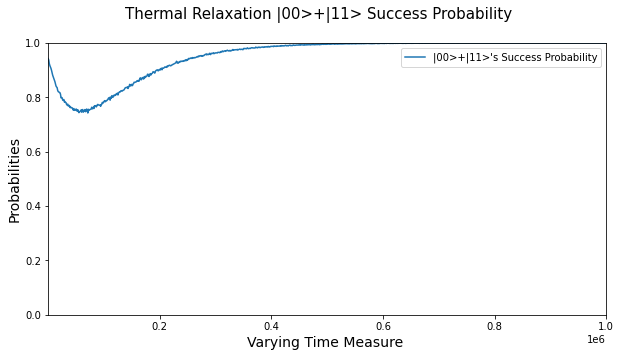

<Figure size 576x360 with 0 Axes>

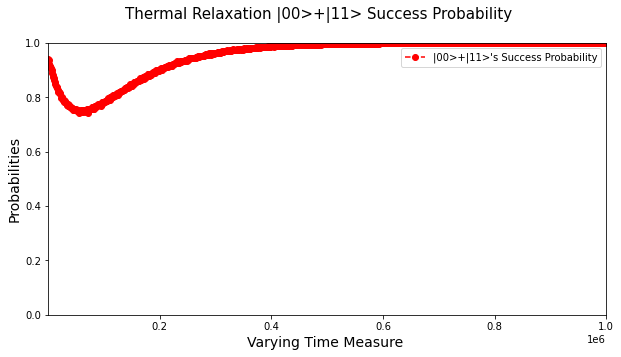

<Figure size 576x360 with 0 Axes>

In [24]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |00>+|11> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,d,label = "|00>+|11>'s Success Probability")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |00>+|11> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,d,'ro--',label = "|00>+|11>'s Success Probability")
ax.legend()

In [21]:
import matplotlib.pyplot as plt

listofSuccess_DMG=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": True, "gate": True}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess_DMG.append(success)
    

In [22]:
from statistics import mean
a= listofSuccess_DMG
print(*map(mean, zip(*a)))

0.94 0.92795 0.9182 0.90915 0.89975 0.88795 0.882 0.8696 0.86735 0.84605 0.8387 0.8321999999999999 0.82265 0.8111 0.8093 0.7997 0.7951 0.7805500000000001 0.772 0.76925 0.75615 0.75085 0.7384 0.7374499999999999 0.72705 0.7138 0.71015 0.7025 0.69945 0.68965 0.6789000000000001 0.6766 0.67115 0.66645 0.6586500000000001 0.64695 0.6374 0.63005 0.6264 0.6142 0.60185 0.6026 0.60315 0.5939 0.5837 0.56945 0.57275 0.57095 0.5680999999999999 0.55515 0.54925 0.54735 0.53585 0.53195 0.53095 0.51875 0.5125500000000001 0.51265 0.50605 0.4955 0.49675 0.48645 0.47885 0.476 0.47605 0.4794 0.46595 0.4582 0.4591 0.44515 0.44325000000000003 0.4392 0.43565 0.4279 0.42314999999999997 0.42569999999999997 0.4115 0.4108 0.41065 0.39640000000000003 0.4008 0.3942 0.38925 0.3821 0.38025 0.3751 0.37425 0.37185 0.36895 0.3582 0.35705 0.35415 0.3497 0.34285 0.34199999999999997 0.34125 0.33635 0.3335 0.33545 0.32755 0.3152 0.31815 0.3159 0.31295 0.311 0.3087 0.30219999999999997 0.2949 0.29735 0.28975 0.2835499999999999

In [25]:
d2=[0.94,0.92795,0.9182,0.90915,0.89975,0.88795,0.882,0.8696,0.86735,0.84605,0.8387,0.8321999999999999,0.82265,0.8111,0.8093,0.7997,0.7951,0.7805500000000001,0.772,0.76925,0.75615,0.75085,0.7384,0.7374499999999999,0.72705,0.7138,0.71015,0.7025,0.69945,0.68965,0.6789000000000001,0.6766,0.67115,0.66645,0.6586500000000001,0.64695,0.6374,0.63005,0.6264,0.6142,0.60185,0.6026,0.60315,0.5939,0.5837,0.56945,0.57275,0.57095,0.5680999999999999,0.55515,0.54925,0.54735,0.53585,0.53195,0.53095,0.51875,0.5125500000000001,0.51265,0.50605,0.4955,0.49675,0.48645,0.47885,0.476,0.47605,0.4794,0.46595,0.4582,0.4591,0.44515,0.44325000000000003,0.4392,0.43565,0.4279,0.42314999999999997,0.42569999999999997,0.4115,0.4108,0.41065,0.39640000000000003,0.4008,0.3942,0.38925,0.3821,0.38025,0.3751,0.37425,0.37185,0.36895,0.3582,0.35705,0.35415,0.3497,0.34285,0.34199999999999997,0.34125,0.33635,0.3335,0.33545,0.32755,0.3152,0.31815,0.3159,0.31295,0.311,0.3087,0.30219999999999997,0.2949,0.29735,0.28975,0.28354999999999997,0.2822,0.2803,0.2812,0.2748,0.2725,0.26645,0.2702,0.2629,0.26315,0.26015,0.25405,0.25565,0.2547,0.24435,0.2449,0.2484,0.23975,0.23335,0.2362,0.23595,0.2279,0.2314,0.2234,0.2281,0.21855,0.2213,0.22,0.2134,0.21295,0.21055,0.20755,0.2111,0.20455,0.19625,0.1927,0.19655,0.19445,0.19165,0.1902,0.18935,0.18914999999999998,0.18375,0.18075,0.18375,0.18215,0.1802,0.174,0.1754,0.1744,0.17165,0.1692,0.16815,0.16620000000000001,0.1574,0.161,0.15525,0.15675,0.15195,0.15284999999999999,0.15255,0.148,0.14825,0.1488,0.14675,0.1475,0.14065,0.14075,0.13875,0.13685,0.1385,0.13695,0.1339,0.13325,0.13535,0.1303,0.1288,0.12535,0.12255,0.12355000000000001,0.12265,0.1197,0.1207,0.119,0.11615,0.11610000000000001,0.1132,0.11515,0.1077,0.10815,0.1096,0.1133,0.10725,0.10515,0.1077,0.1079,0.10395,0.0987,0.10225000000000001,0.10149999999999999,0.0992,0.10005,0.09845,0.097,0.094,0.09475,0.094,0.0906,0.0875,0.08645,0.09055,0.0901,0.08839999999999999,0.08955,0.08125,0.0884,0.08235,0.0783,0.08075,0.0781,0.0816,0.07695,0.07665,0.0821,0.0808,0.0766,0.07385,0.0756,0.07365,0.07175000000000001,0.0719,0.0721,0.0726,0.07045,0.0688,0.0686,0.06835,0.06760000000000001,0.0671,0.06420000000000001,0.0621,0.0613,0.06465,0.0627,0.06305,0.06025,0.06415,0.06065,0.0566,0.05705,0.0567,0.0577,0.060450000000000004,0.0551,0.0557,0.05425,0.05365,0.0535,0.0558,0.0524,0.05315,0.0509,0.0494,0.0507,0.0474,0.052199999999999996,0.0485,0.047599999999999996,0.0497,0.0463,0.04585,0.04595,0.0477,0.04665,0.04345,0.044449999999999996,0.0414,0.04405,0.04505,0.04265,0.0435,0.04235,0.0414,0.044199999999999996,0.04135,0.03945,0.0388,0.0413,0.04085,0.035750000000000004,0.03775,0.038,0.04025,0.0352,0.0355,0.03535,0.0345,0.035250000000000004,0.03385,0.03155,0.03305,0.034,0.03455,0.032100000000000004,0.0333,0.0308,0.0291,0.0326,0.032350000000000004,0.0294,0.0311,0.03235,0.0301,0.02885,0.03005,0.02905,0.030350000000000002,0.02905,0.0298,0.02915,0.0279,0.02745,0.02715,0.0276,0.0274,0.02695,0.02775,0.0235,0.022600000000000002,0.02515,0.0253,0.02535,0.0245,0.02485,0.02315,0.02445,0.02245,0.02285,0.0245,0.02245,0.0234,0.02195,0.0212,0.02155,0.02,0.0204,0.019799999999999998,0.01845,0.0201,0.0202,0.01845,0.0205,0.0203,0.0198,0.01795,0.01935,0.01805,0.0184,0.01955,0.0183,0.0184,0.0159,0.01825,0.01725,0.0168,0.01635,0.01645,0.0184,0.01715,0.01565,0.0146,0.0161,0.01625,0.01505,0.01515,0.016,0.0144,0.01415,0.01445,0.01595,0.015,0.01485,0.0136,0.0135,0.0133,0.01375,0.01225,0.014,0.012199999999999999,0.0135,0.01475,0.01285,0.0128,0.01325,0.01285,0.01295,0.011899999999999999,0.012,0.01195,0.013049999999999999,0.0115,0.0119,0.0105,0.011,0.0113,0.0116,0.01,0.00955,0.0107,0.00995,0.01035,0.01075,0.0113,0.0094,0.0096,0.01065,0.0089,0.0098,0.01005,0.0089,0.0088,0.0096,0.009899999999999999,0.01035,0.00905,0.008,0.00935,0.00945,0.0082,0.00955,0.00755,0.00825,0.0073,0.0075,0.00815,0.0078,0.009049999999999999,0.00775,0.007899999999999999,0.00765,0.0078,0.00735,0.0069,0.0073,0.0076,0.00725,0.0073,0.0070999999999999995,0.0062,0.00775,0.0068000000000000005,0.0064,0.00715,0.0057,0.00735,0.00695,0.0066,0.00675,0.00595,0.00525,0.00685,0.00675,0.00535,0.00675,0.0058,0.0059,0.00615,0.0062,0.00565,0.0056500000000000005,0.0055,0.0055,0.00535,0.0044,0.00565,0.00535,0.0052,0.005,0.00655,0.00475,0.00475,0.0052,0.0048000000000000004,0.0053,0.00485,0.005,0.0039000000000000003,0.00485,0.00495,0.0048000000000000004,0.0043,0.0044,0.00395,0.004,0.0042,0.0043,0.0039000000000000003,0.0044,0.00355,0.00435,0.00465,0.00435,0.004,0.0032,0.0034000000000000002,0.0036,0.00355,0.00375,0.00355,0.00385,0.00385,0.0035,0.0042,0.00415,0.00305,0.00315,0.0032500000000000003,0.0031,0.0032,0.00345,0.0027,0.0032,0.00355,0.0024000000000000002,0.0036,0.0039000000000000003,0.0024000000000000002,0.0028,0.00285,0.0024000000000000002,0.00245,0.0026,0.003,0.003,0.0025,0.00285,0.0028,0.00245,0.00355,0.00265,0.0026,0.0032,0.0025,0.00245,0.00265,0.00265,0.0032,0.00285,0.00235,0.00245,0.0022,0.0028,0.0016,0.002,0.0019,0.00215,0.0019,0.0025,0.00215,0.0021,0.00185,0.0022500000000000003,0.00255,0.0017000000000000001,0.0019500000000000001,0.0016,0.0019500000000000001,0.0021,0.00205,0.0019,0.00235,0.0017000000000000001,0.00125,0.00215,0.0018,0.00185,0.00165,0.0016,0.0017000000000000001,0.0019,0.0017000000000000001,0.00205,0.0017000000000000001,0.0019,0.0014500000000000001,0.0012000000000000001,0.00175,0.0013,0.00165,0.0019,0.0015,0.0018,0.00135,0.0016,0.0012000000000000001,0.0015,0.0012000000000000001,0.0014500000000000001,0.0014,0.0014,0.0007,0.0014,0.00215,0.0011,0.00105,0.00125,0.00135,0.0013,0.0014,0.00135,0.00155,0.0012000000000000001,0.001,0.0013,0.00105,0.0008,0.001,0.001,0.001,0.0009,0.00105,0.0011,0.0016,0.00125,0.0009,0.0014,0.001,0.0006000000000000001,0.0012000000000000001,0.0011,0.0012000000000000001,0.0012000000000000001,0.0007,0.00115,0.0008,0.00105,0.0008,0.00095,0.0008,0.0012000000000000001,0.0008500000000000001,0.00075,0.00095,0.0008500000000000001,0.00055,0.00095,0.00075,0.001,0.0008500000000000001,0.00045,0.00105,0.00075,0.0006000000000000001,0.0006000000000000001,0.0011,0.00065,0.0009,0.0005,0.00075,0.00065,0.0005,0.0008,0.0009,0.0007,0.0006000000000000001,0.00065,0.00095,0.0008,0.001,0.00065,0.00055,0.0004,0.00065,0.0006000000000000001,0.00065,0.00105,0.00095,0.001,0.00055,0.00045,0.0004,0.00055,0.00075,0.00030000000000000003,0.00025,0.0007,0.0005,0.00075,0.00075,0.00055,0.0004,0.00035,0.00030000000000000003,0.00055,0.00075,0.00055,0.0007,0.00030000000000000003,0.00045,0.00015000000000000001,0.00055,0.0007,0.0005,0.00065,0.0004,0.00065,0.0005,0.0005,0.0004,0.00025,0.00030000000000000003,0.00055,0.0004,0.00030000000000000003,0.00075,0.0005,0.0007,0.00045,0.00035,0.0002,0.00030000000000000003,0.00030000000000000003,0.00045,0.0005,0.00025,0.00030000000000000003,0.00065,0.0002,0.00035,0.0002,0.0006000000000000001,0.0005,0.00055,0.00025,0.0005,0.0002,0.00030000000000000003,0.00025,0.0002,0.0002,0.00030000000000000003,0.0004,0.00015000000000000001,0.00030000000000000003,0.0002,0.00025,0.00035,0.00015000000000000001,0.0004,0.0005,0.00030000000000000003,0.00030000000000000003,0.00035,0.00045,0.0004,0.0002,0.00025,0.0002,0.0002,0.0001,0.00015000000000000001,0.00015000000000000001,0.00015000000000000001,0.00030000000000000003,5e-05,0.00015000000000000001,0.0002,0.00035,0.0002,0.00025,0.00025,0.00025,5e-05,0.0002,0.00025,0.00015000000000000001,5e-05,0.00030000000000000003,0.00025,0.00015000000000000001,0.0002,0.00025,0.0001,0.0002,0.00015000000000000001,0.0002,0.00025,0.0001,0.0001,0.00025,0.00025,0.00035,0.00015000000000000001,0.00025,0.00030000000000000003,0.0001,5e-05,0.0001,0.00025,0.00015000000000000001,0.0002,0.00015000000000000001,0.0001,0.0001,0.0001,0.0001,0.00030000000000000003,0.0001,0.0002,0.0001,0.0002,0.0001,0.0001,5e-05,0.0001,0.0,0.00025,0.0001,0.0002,0.0001,0.0,0.0001,0.00015000000000000001,0.00015000000000000001,0.0002,5e-05,0.0001,0.0001,0.0001,5e-05,0.0,5e-05,0.00015000000000000001,0.0002,0.0001,0.0,5e-05,0.0,0.00015000000000000001,0.00015000000000000001,0.0001,0.00030000000000000003,0.00015000000000000001,0.0001,0.0,0.0001,0.00015000000000000001,0.00015000000000000001,0.00015000000000000001,0.00025,5e-05,0.0,5e-05,0.0001,0.0001,0.00015000000000000001,5e-05,0.00015000000000000001,0.0001,0.00025,0.0001,0.0002,0.0,5e-05,5e-05,0.0001,5e-05,0.0,0.0001,5e-05,5e-05,0.0001,0.0002,5e-05,0.0,5e-05,0.0,5e-05,5e-05,0.0002,5e-05,0.00015000000000000001,0.00015000000000000001,0.0001,0.0001,0.0,5e-05,5e-05,5e-05,0.0001,0.0001,0.0,5e-05,0.0001,0.0,5e-05,0.0001,0.0,0.0001,0.0,0.0,0.0,0.0001,0.0,5e-05,0.0,0.0001,0.0001,0.0,0.0001,0.0,5e-05,0.0001,0.0,0.0001,0.0001,0.0,0.0,0.0001,0.0,0.0,0.0,0.0,5e-05,5e-05,0.0,0.00015000000000000001,0.00015000000000000001,0.0,0.0001,0.00015000000000000001,5e-05,0.0,0.0001,5e-05,0.0,0.0,0.0,0.0,5e-05,0.0,5e-05,0.0,0.0,0.0,0.0,0.0001,0.0,5e-05,5e-05,5e-05,5e-05,0.0,0.0,5e-05,0.0,0.0001,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,5e-05,0.0,0.00015000000000000001,5e-05,5e-05,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,5e-05,0.0,0.0,0.0,0.0,5e-05,0.0,0.0001,0.0,0.0]

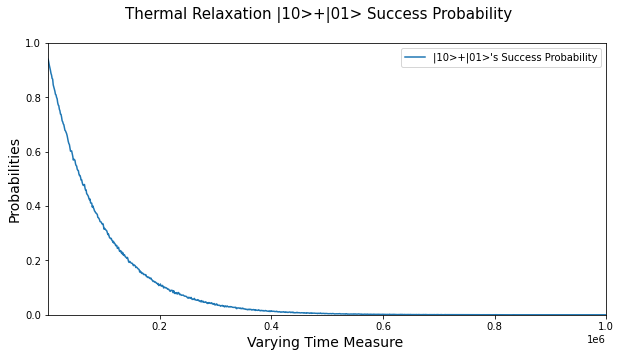

<Figure size 576x360 with 0 Axes>

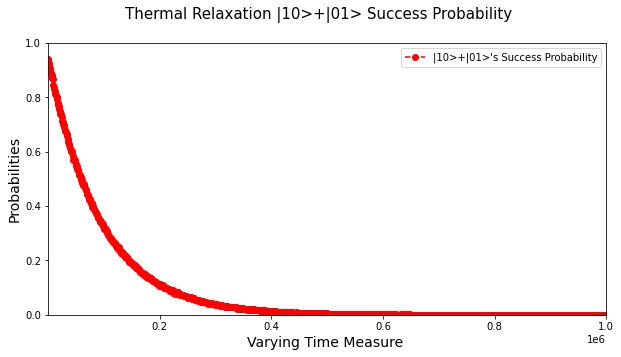

<Figure size 576x360 with 0 Axes>

In [26]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |10>+|01> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,d2,label = "|10>+|01>'s Success Probability")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |10>+|01> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,d2,'ro--',label = "|10>+|01>'s Success Probability")
ax.legend()

# Graph Compairing

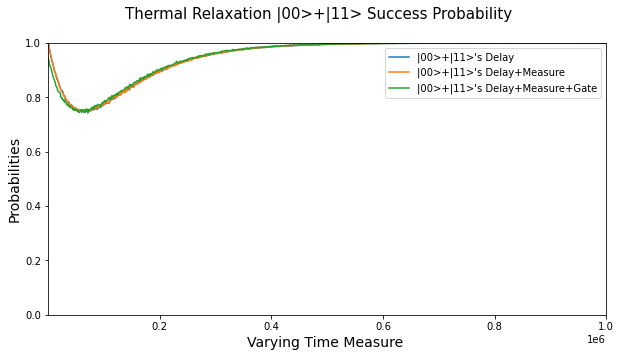

<Figure size 576x360 with 0 Axes>

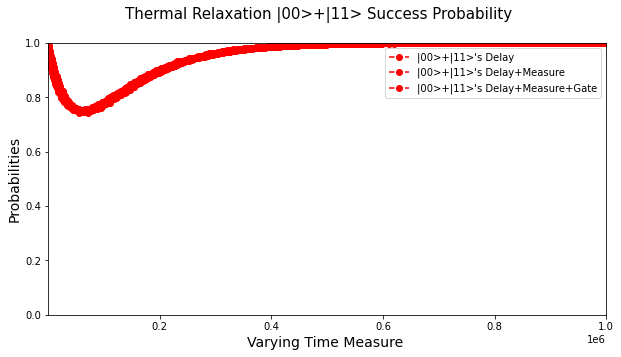

<Figure size 576x360 with 0 Axes>

In [27]:
x1=b
x2=c
x3=d
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |00>+|11> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,x1,label = "|00>+|11>'s Delay")
ax.plot(delay,x2,label = "|00>+|11>'s Delay+Measure")
ax.plot(delay,x3,label = "|00>+|11>'s Delay+Measure+Gate")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |00>+|11> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,x1,'ro--',label = "|00>+|11>'s Delay")
ax.plot(delay,x2,'ro--',label = "|00>+|11>'s Delay+Measure")
ax.plot(delay,x3,'ro--',label = "|00>+|11>'s Delay+Measure+Gate")
ax.legend()


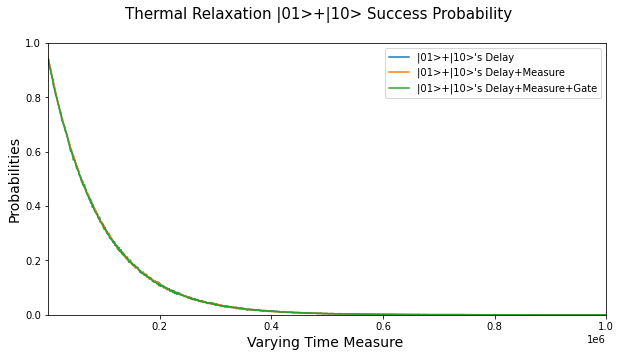

<Figure size 576x360 with 0 Axes>

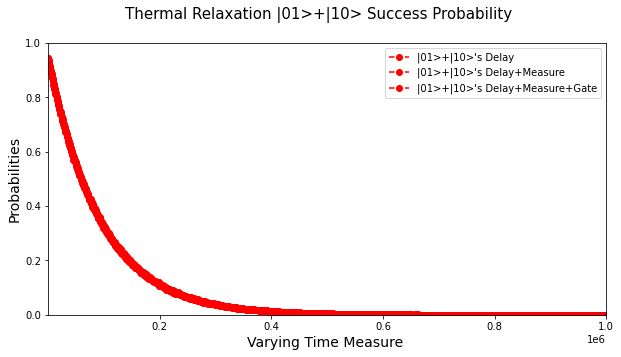

<Figure size 576x360 with 0 Axes>

In [30]:
x1=b2
x2=c2
x3=d2
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |01>+|10> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,x1,label = "|01>+|10>'s Delay")
ax.plot(delay,x2,label = "|01>+|10>'s Delay+Measure")
ax.plot(delay,x3,label = "|01>+|10>'s Delay+Measure+Gate")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |01>+|10> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,x1,'ro--',label = "|01>+|10>'s Delay")
ax.plot(delay,x2,'ro--',label = "|01>+|10>'s Delay+Measure")
ax.plot(delay,x3,'ro--',label = "|01>+|10>'s Delay+Measure+Gate")
ax.legend()